(48, 1)


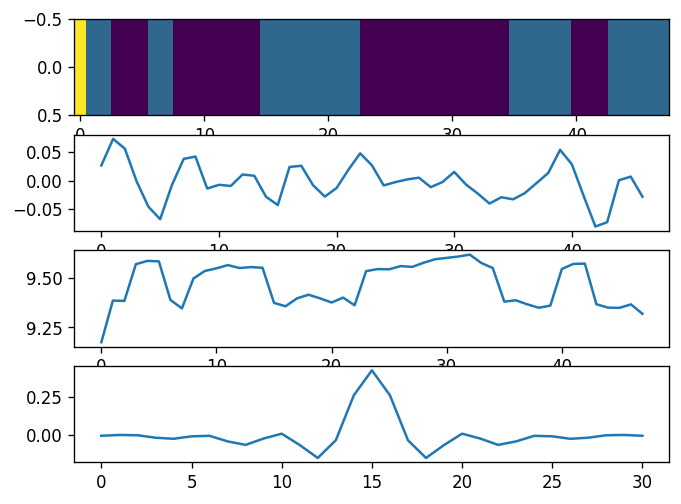

In [251]:
from importlib import reload 
import numpy as np
import h5py
from utils import *
import time
import json

## Prior parameter ##
nl_level = 10

PRIOR = np.ones(4, dtype=[('MU', float, (4)), ('C', float, (4,4))])

mu = np.ones([4,4])
mu[0] = [8.5948, 8.0356, 0.9613, 9.5561]
mu[1] = [8.4563, 7.8829, 0.9186, 9.3749]
mu[2] = [8.6676, 8.0483, 1.0716, 9.7392]
mu[3] = [8.4136, 7.8345, 0.7348, 9.1484]
#print(mu)

c = np.ones([4,4,4])
c[0,:] = [[0.0037, 0.0027, 0.0008, 0.0000],
            [0.0027, 0.0030, 0.0008, 0.0000],
            [0.0008, 0.0008, 0.0003, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0111]]

c[1,:] = [[0.0032, 0.0028, 0.0011, 0.0000],
            [0.0028, 0.0033, 0.0010, 0.0000],
            [0.0011, 0.0010, 0.0006, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0096]]

c[2,:] = [[0.0023, 0.0016, 0.0008, 0.0000],
            [0.0016, 0.0017, 0.0007, 0.0000],
            [0.0008, 0.0007, 0.0006, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0070]]

c[3,:] = [[0.0008, 0.0005, 0.0003, 0.0000],
            [0.0005, 0.0004, 0.0002, 0.0000],
            [0.0003, 0.0002, 0.0003, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0023]]
#print(c)

wavelet_new = [-1039.55055580727,
            -4026.57620068033,
            -8194.18572794536,
            -11356.0387947636,
            -11906.6435543803,
            -10191.4389229172,
            -8639.29324618705,
            -10474.3682826362,
            -17093.5087710456,
            -25733.4288332681,
            -29906.2345220425,
            -23088.0727988944,
            -3091.80943987738,
            25306.1208726887,
            51180.4184438887,
            63288.5822013372,
            53619.9099732780,
            32940.2018555759,
            11743.5370194762,
            -3175.56289063239,
            -10845.0261972202,
            -13246.6910319655,
            -12569.5536619989,
            -10329.2514738468,
            -7512.57465309683,
            -5018.31852539635,
            -3551.82629919458,
            -3000.47980521376,
            -2436.41725067266,
            -1305.36051838710,
            -346.558408174331]

PRIOR['MU'] = mu
PRIOR['C'] = c

## Geracao do ensemble ##
n = 48
I = n
J = 1
signal2noise = 5
v_fact = 0.1

wavelet = np.array(wavelet_new)

delta = np.zeros([31,1])
delta[np.around(delta.shape[0]/2).astype(int)-1,0] = 1

wavelet = lowPassFilter2(delta,4,40,60) - lowPassFilter2(delta,4,40,6)

G = acoustic_foward_matrix(wavelet,I)

#P = np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.1 0.1 0.1 0.7')
P = np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.1 0.1 0.1 0.7')
P = np.array(P)

facies = simulate_markov_chain(P,n,3,1)
print(facies.shape)
mu, log_imp, seismic = facies_forward_model(facies, PRIOR, G, v_fact)

noise = np.random.randn(I-1,1)
noise = noise/np.std(noise)
std_noise = np.std(seismic)/np.sqrt(signal2noise)
noise = noise*std_noise
seismic = seismic + noise.ravel()

fig, axs = plt.subplots(4)
fig.set_dpi(120)
axs[0].imshow(facies.transpose(), aspect='auto')
axs[1].plot(seismic)
axs[2].plot(log_imp)
axs[3].plot(wavelet)
plt.show()

# Gera modelo

C:\Users\rodri\AppData\Local\Temp\ipykernel_51732\2368569923.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


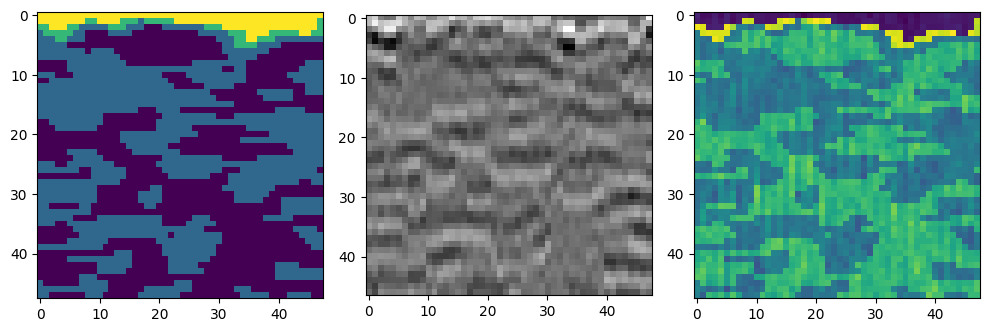

In [253]:
from scipy.ndimage.filters import gaussian_filter

#Pver = np.array(np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.066 0.066 0.066 0.802'))
Pver = np.array(np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.15 0.15 0.15 0.55'))

Phor = np.array(np.matrix('0.4 0.4 0.1 0.1; 0.4 0.4 0.1 0.1; 0.1 0.1 0.6 0.2; 0.1 0.1 0.2 0.6'))

#Simulation grid size

I = 48
J = 48
initial_facies = 3

prior_map = np.ones([I, J, 4])

simulation = simulate_markov_2Dchain(Phor, Pver, prior_map, initial_facies)
ss = gaussian_filter(simulation, sigma=[0.5, 1.5])
st = simulation == 3
ss[st] = 3
ss = np.round(gaussian_filter(ss, sigma=[0.5 , 1.5]))

def facies_forward_model_2D(facies, PRIOR, G, v_fact):
  seismics = []
  impedances = []
  for j in range(0,J):
    mu, log_imp, seismic = facies_forward_model(facies[:,j], PRIOR, G, v_fact)
    seismics.append(seismic)
    impedances.append(log_imp)

  seismics = np.array(seismics).transpose()
  impedances = np.array(impedances).transpose()
  return seismics, impedances

seis, immp = facies_forward_model_2D(ss, PRIOR, G, v_fact)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
axes[0].imshow(ss)
axes[1].imshow(seis, cmap='gray')
axes[2].imshow(immp)
fig.tight_layout()

In [314]:
np.save('referencia_rede_2.npy', ss)

In [316]:
ss = np.load("referencia_rede.npy")

In [313]:
ss = ss.numpy()

# Carrega o dataset em H5

In [68]:
import numpy as np
import h5py
hf = h5py.File('data_48x48_2D.h5', 'r')
#hf = h5py.File('data_60x60_2D.h5', 'r')
X_bk = np.array(hf['X'])
hf.close()
print(X_bk.shape)
X = np.copy(X_bk)
X = tf.keras.utils.to_categorical(X, num_classes=4)
print(X.shape)

(15000, 48, 48)
(15000, 48, 48, 4)


# Cria o dataset

IntProgress(value=0, max=15000)

(15000, 60, 60)


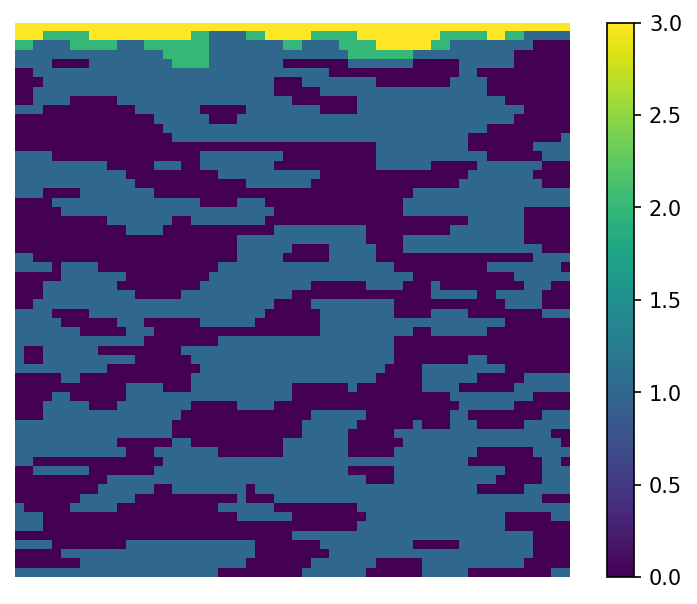

Data generation time (s):  26543.766520023346


In [86]:
from ipywidgets import IntProgress
from IPython.display import display
import time

def create_train_data(data_size = 512, i = 48, j = 48):
  initial_facies = 3
  prior_map = np.ones([i, j, 4])
  
  f = IntProgress(min=0, max=data_size) # instantiate the bar
  display(f)

  data = np.zeros([data_size, i, j])
  for i in range(0, data_size):
    simulation = simulate_markov_2Dchain(Phor, Pver, prior_map, initial_facies)
    ss = gaussian_filter(simulation, sigma=[0.5, 1.5])
    st = simulation == 3
    ss[st] = 3
    ss = np.round(gaussian_filter(ss, sigma=[0.5 , 1.5]))
    data[i] = ss
    f.value += 1
  return data

start_time = time.time()
X_bk = create_train_data(15000, 60, 60)
print(X_bk.shape)
h5f = h5py.File('data_60x60_2D.h5', 'w')
h5f.create_dataset('X', data=X_bk)
h5f.close()

fig = plt.figure(dpi=150)
fig.colorbar(plt.imshow(X_bk[0]))
plt.axis('off')
plt.show()
#print(X_bk)
#X_bk = np.expand_dims(X_bk.transpose(), axis=2)
print('Data generation time (s): ', (time.time() - start_time))

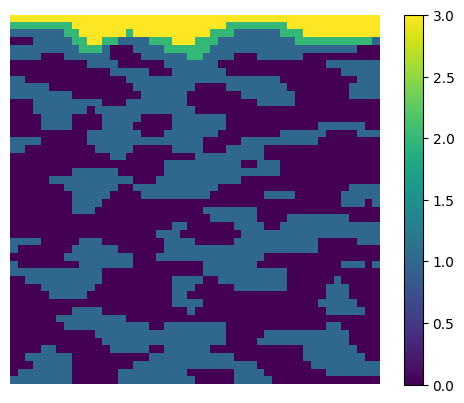

In [317]:
fig = plt.figure()
fig.colorbar(plt.imshow(ss))
plt.axis('off')
plt.show()

# Normaliza o modelo

In [13]:
X = np.copy(X_bk).astype(dtype='float32')
X /= X.max()
#X = (X - 0.5) / 0.5 # normalize (-1,1)
X = np.expand_dims(X, axis=3)
#X = np.transpose(X, axes=(0,2,1,3))
#X = tf.keras.utils.to_categorical(X)
print(X.shape)
print(X_bk.min(),X_bk.max())
print(X.min(),X.max())

(500, 60, 60, 1)
0.0 3.0
0.0 1.0


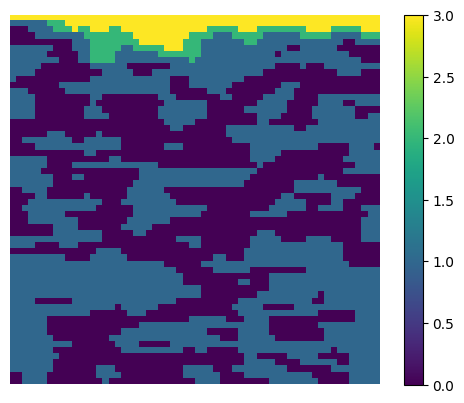

In [42]:
fig = plt.figure()
fig.colorbar(plt.imshow(np.argmax(tf.keras.utils.to_categorical(X_bk, num_classes=4)[0],axis=-1)))
plt.axis('off')
plt.show()

In [41]:
np.argmax(tf.keras.utils.to_categorical(X_bk, num_classes=4)[0],axis=-1).shape

(60, 60)

# Treinamento

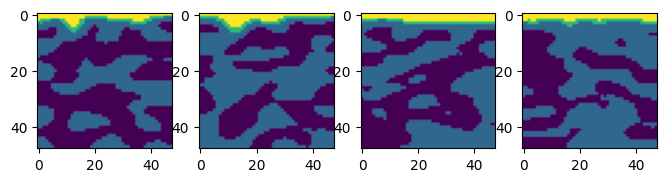

INFO:tensorflow:Assets written to: vae_f/encoder\assets
INFO:tensorflow:Assets written to: vae_f/decoder\assets


In [203]:
%reload_ext autoreload
%autoreload 2
from IPython.display import clear_output
import tensorflow as tf
from vae_models import *

tf.config.set_soft_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

csv_logger = tf.keras.callbacks.CSVLogger("vae_history.csv", append=True)

class SampleImgs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        rn = tf.random.normal(shape=[4, vae.latent_dim])
        fig,axs = plt.subplots(1,4, figsize=(8,6))
        for i in range(0,4):
            axs[i].imshow(vae.decode(rn)[i])
        plt.show()

vae = VAE()
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
#vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
#vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule))
history = vae.fit(X, epochs=50, batch_size=8, callbacks=[SampleImgs(), csv_logger])
tf.keras.models.save_model(vae.encoder, "vae_f/encoder")
tf.keras.models.save_model(vae.decoder, "vae_f/decoder")

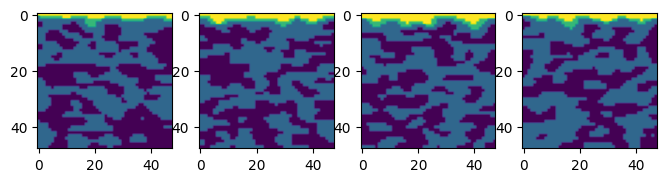

INFO:tensorflow:Assets written to: fcvae_2/encoder\assets
INFO:tensorflow:Assets written to: fcvae_2/decoder\assets


In [320]:
%reload_ext autoreload
%autoreload 2
from IPython.display import clear_output
import tensorflow as tf
from vae_models import *

tf.config.set_soft_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

csv_logger = tf.keras.callbacks.CSVLogger("fcvae_history.csv", append=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

class ViewReconstruction(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        rnd = random.randint(0, X.shape[0]-1)
        rnd_img = tf.expand_dims(X[0], axis=0)
        z_mean, z_log_var, z = fcvae.encoder(rnd_img)
        fig,axs = plt.subplots(1,4, figsize=(6,4))
        #axs[0].imshow((rnd_img)[0])
        #axs[1].imshow(np.around(fcvae.decoder(z)[0]*3))
        axs[0].imshow(np.argmax((rnd_img)[0], axis=-1))
        axs[1].imshow(fcvae.decode(z)[0])
        axs[2].hist(z.numpy().flatten())
        axs[3].imshow(z.numpy().reshape((fcvae.latent_dim,fcvae.latent_dim)))
        fig.tight_layout()
        plt.show()

class SampleImgs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        rn = tf.random.normal(shape=[4, fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size])
        fig,axs = plt.subplots(1,4, figsize=(8,6))
        for i in range(0,4):
            axs[i].imshow(fcvae.decode(rn)[i])
        plt.show()

fcvae = FCVAE(img_size=X.shape[1], lat_size=2)
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
#fcvae.compile(optimizer=tf.keras.optimizers.RMSprop())
#fcvae.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule))
fcvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
#fcvae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
fcvae.fit(X, epochs=50, batch_size=8, callbacks=[SampleImgs(), csv_logger, early_stop])
tf.keras.models.save_model(fcvae.encoder, "fcvae_2/encoder")
tf.keras.models.save_model(fcvae.decoder, "fcvae_2/decoder")

In [18]:
fcvae.encoder = tf.keras.models.load_model("fcvae/encoder")
fcvae.decoder = tf.keras.models.load_model("fcvae/decoder")

# Imprime amostragens

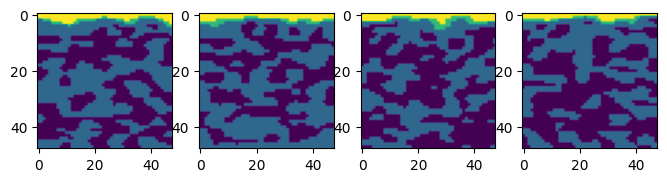

In [306]:
rn = tf.random.normal(shape=[4, fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size])#+(0.1*tf.random.uniform(shape=[2, fcvae.latent_dim, fcvae.latent_dim, 1]))
#rn = tf.random.normal(shape=[2, fcvae.latent_dim*fcvae.latent_dim])
#rn = tf.reshape(rn, shape=(2, fcvae.latent_dim, fcvae.latent_dim, 1))
#rn = tf.random.normal(shape=[2, vae.latent_dim])

fig,axs = plt.subplots(1,4, figsize=(8,6))
gens_imgs = fcvae.decode(rn)
for i in range(0,4):
    axs[i].imshow(gens_imgs[i])
plt.show()

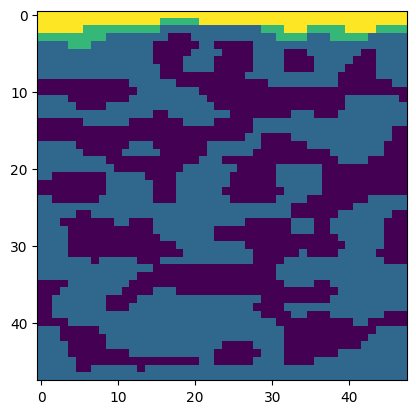

In [309]:
ss = gens_imgs[1]
plt.imshow(ss)
plt.show()

# função

In [108]:
def plt_ensamble(modelo_samples):
    #w, h = int(math.sqrt(n_samples)), int(math.sqrt(n_samples))    
    w = 1
    h = 4
    

    fig, axs = plt.subplots(1,4, figsize=(8, 2), dpi=150)
    plt.xticks(fontsize=6)
    #gan_facies = tf.experimental.numpy.around(cvae.sample(eps=modelo_samples)*3)
    idx = 0
    for i in range(0,1):
        for j in range(0,4):
            axs[j].hist(tf.reshape(modelo_samples[idx], [modelo_samples.shape[1], modelo_samples.shape[2], modelo_samples.shape[3]]).numpy().flatten())
            idx = idx + 1
    #fig.tight_layout()
    for axr in axs:
        axr.xaxis.set_tick_params(labelsize=6)
        axr.yaxis.set_tick_params(labelsize=6)
    plt.show()
    
    fig, axs = plt.subplots(w,h, figsize=(8, 2), dpi=150)
    #gan_facies = tf.experimental.numpy.around(cvae.sample(eps=modelo_samples)*3)
    gan_facies = fcvae.decode(modelo_samples)
    idx = 0
    for i in range(0,w):
        for j in range(0,h):
            axs[j].imshow(tf.reshape(gan_facies[idx], [n,n]))
            axs[j].axis('off')
            #axs[i,j].set_xticklabels([])
            #axs[i,j].set_yticklabels([])
            #axs[i,j].set_aspect('equal')
            idx = idx + 1
    #fig.tight_layout()
    plt.show()
    
def plt_ensamble_dense(modelo_samples): 
    w = 1
    h = 4
    fig, axs = plt.subplots(1,4, figsize=(8, 2), dpi=150)
    plt.xticks(fontsize=6)
    idx = 0
    for i in range(0,1):
        for j in range(0,4):
            #axs[j].hist(tf.reshape(modelo_samples[idx], [modelo_samples.shape[1], modelo_samples.shape[2]]).numpy().flatten())
            axs[j].hist(tf.reshape(modelo_samples[idx], [modelo_samples.shape[1],1]).numpy().flatten())
            idx = idx + 1
    #fig.tight_layout()
    for axr in axs:
        axr.xaxis.set_tick_params(labelsize=6)
        axr.yaxis.set_tick_params(labelsize=6)
    plt.show()
    
    fig, axs = plt.subplots(w,h, figsize=(8, 2), dpi=150)
    #gan_facies = tf.experimental.numpy.around(cvae.sample(eps=modelo_samples)*3)
    gan_facies = vae.decode(modelo_samples)
    idx = 0
    for i in range(0,w):
        for j in range(0,h):
            axs[j].imshow(tf.reshape(gan_facies[idx], [n,n]))
            axs[j].axis('off')
            #axs[i,j].set_xticklabels([])
            #axs[i,j].set_yticklabels([])
            #axs[i,j].set_aspect('equal')
            idx = idx + 1
    #fig.tight_layout()
    plt.show()
#plt_ensamble(modelo_samples)

In [36]:
all_f = vae.decoder.predict(ms.numpy().reshape(ensize, vae.latent_dim, vae.latent_dim, 1))
print(all_f.shape, all_f.min(), all_f.max())

(2000, 48, 48, 1) 0.0 1.0


In [37]:
from ipywidgets import interact, interactive, fixed, interact_manual
def fs(z):
    cmap = plt.get_cmap('viridis', 4)
    fig, axs = plt.subplots(1,4, figsize=(15, 6))
    fig.colorbar(axs[0].imshow(tf.squeeze(mr), cmap=cmap), fraction=0.046, pad=0.04)
    fig.colorbar(axs[1].imshow(facies_es, cmap=cmap), fraction=0.046, pad=0.04)
    fig.colorbar(axs[2].imshow(tf.reshape(np.around(all_f[z]*3), [n,n]), cmap=cmap), fraction=0.046, pad=0.04)
    fig.colorbar(axs[3].imshow(tf.keras.metrics.mse(tf.expand_dims(tf.reshape(np.around(all_f[z]*3), [n,n]),-1), tf.expand_dims(tf.squeeze(mr),-1))), fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()

interactive_plot = interactive(fs, z=(0,all_f.shape[0]-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=999, description='z', max=1999), Output()), _dom_classes=('widget-intera…

In [32]:
tf.keras.metrics.mse(facies_es[0,:], tf.squeeze(mr)[0,:])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [31]:
tf.reduce_mean(tf.keras.metrics.mse(all_f[0], tf.expand_dims(tf.squeeze(mr),-1)))


<tf.Tensor: shape=(), dtype=float32, numpy=0.61058223>

In [30]:
tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(tf.reshape(np.around(all_f[0]*3), [n,n]),-1), tf.expand_dims(tf.squeeze(mr),-1)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.33506945>

In [22]:
mr.numpy().max()

3.0

In [32]:
print(tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(facies_es,-1), tf.expand_dims(tf.squeeze(mr),-1))))

tf.Tensor(0.2825521, shape=(), dtype=float32)


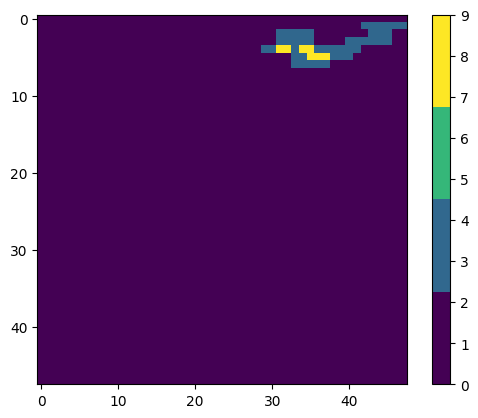

In [35]:
cmap = plt.get_cmap('viridis', 4)
fig = plt.figure()
fig.colorbar(plt.imshow(tf.keras.metrics.mse(tf.expand_dims(facies_es,-1), tf.expand_dims(tf.squeeze(mr),-1)), cmap=cmap))
plt.show()

In [37]:
esmda_loss = tf.Variable(tf.zeros([updts]))
esmda_loss[0].assign(2.233)
esmda_loss

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([2.233, 0.   , 0.   , 0.   ], dtype=float32)>

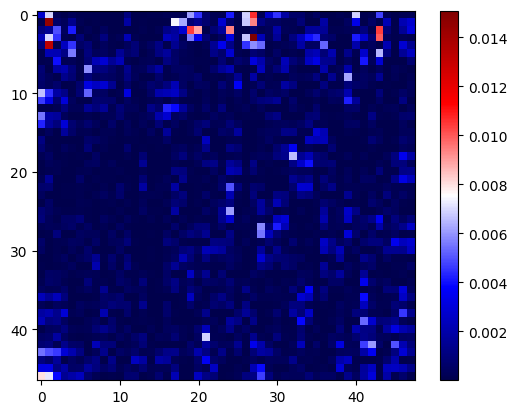

In [46]:
tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(sismica_es.reshape(n-1,n),-1), tf.expand_dims(tf.reshape(seis_exp,[n-1,n]),-1)))
fig = plt.figure()
fig.colorbar(plt.imshow(tf.keras.metrics.mse(tf.expand_dims(sismica_es.reshape(n-1,n),-1), tf.expand_dims(tf.reshape(seis_exp,[n-1,n]),-1)), cmap='seismic'))
plt.show()
#mse_imp = tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(imp_es.reshape(n,n),-1), tf.expand_dims(tf.squeeze(imp_exp.numpy().reshape(n,n)),-1)))

tf.Tensor(0.0126014985, shape=(), dtype=float32)


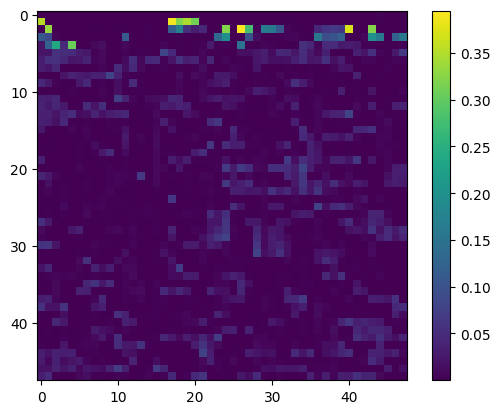

In [48]:
print(tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(imp_es.reshape(n,n),-1), tf.expand_dims(tf.reshape(imp_exp,[n,n]),-1))))
fig = plt.figure()
fig.colorbar(plt.imshow(tf.keras.metrics.mse(tf.expand_dims(imp_es.reshape(n,n),-1), tf.expand_dims(tf.reshape(imp_exp,[n,n]),-1))))
plt.show()

# ESMDA VAE

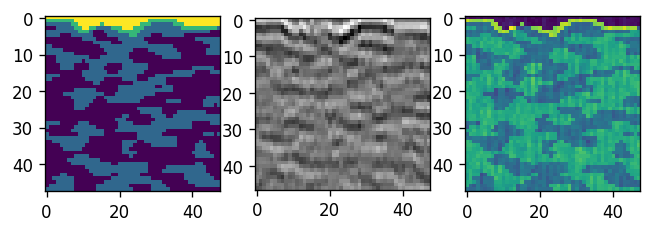

Initial ensemble...


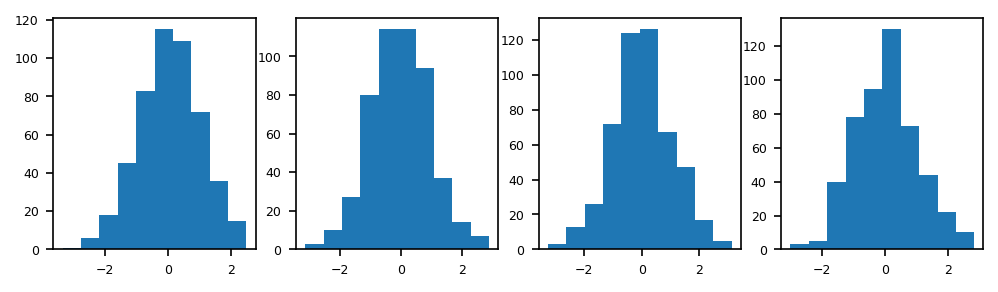

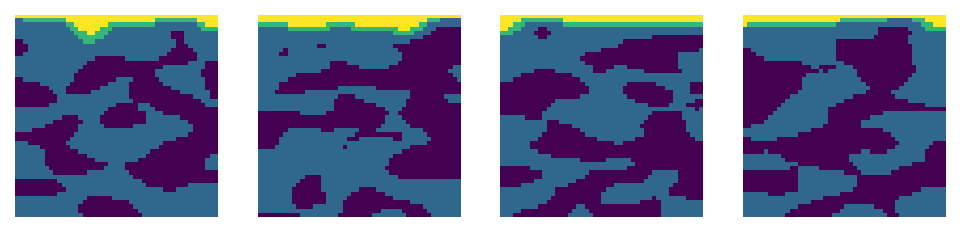

Update  1


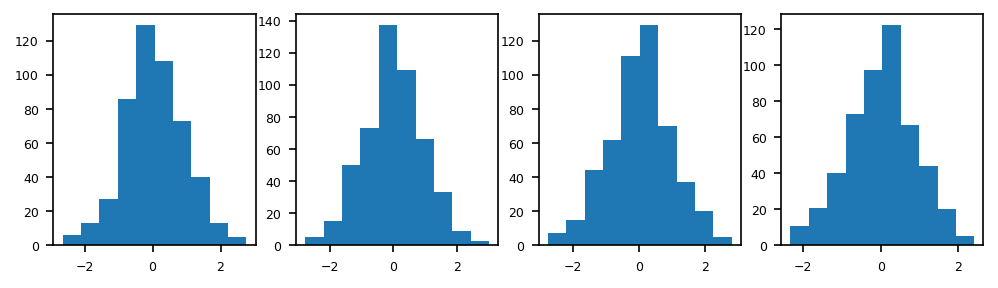

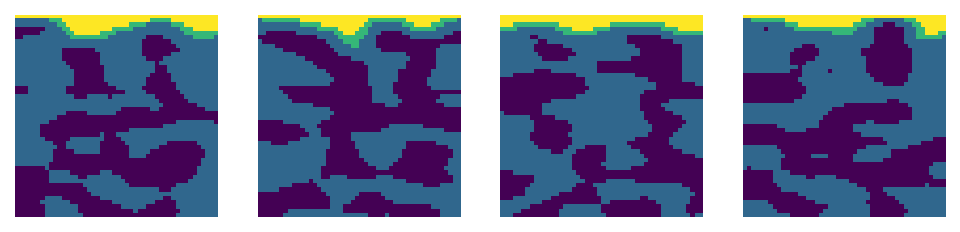

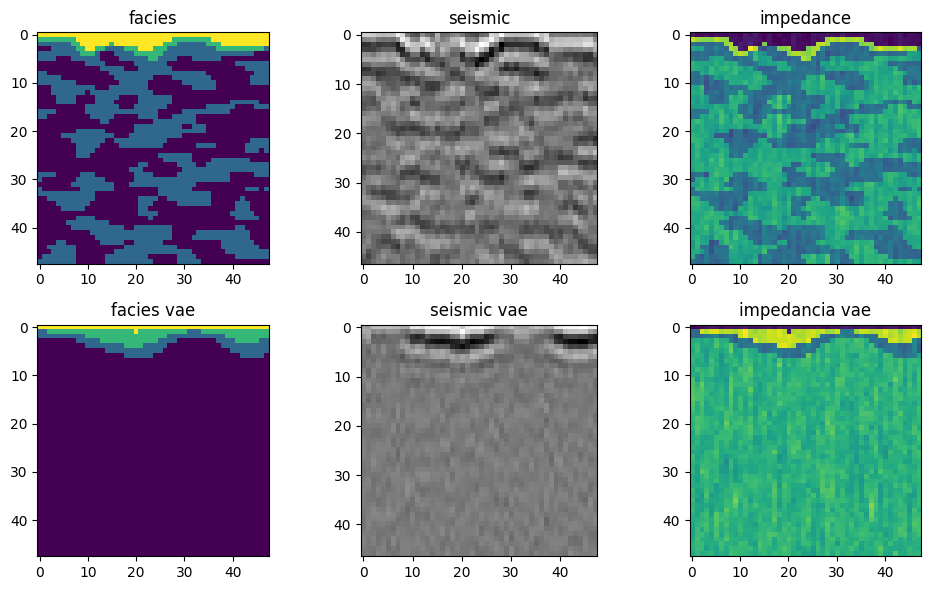

MSE model: [0.4418403 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.       ]
MSE seismic: [0.00195011 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  2


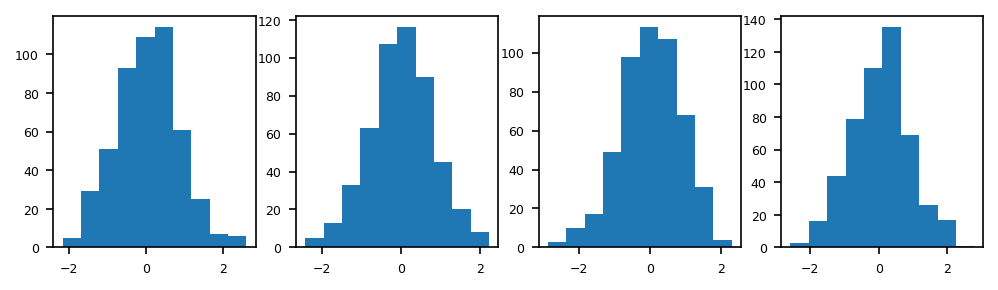

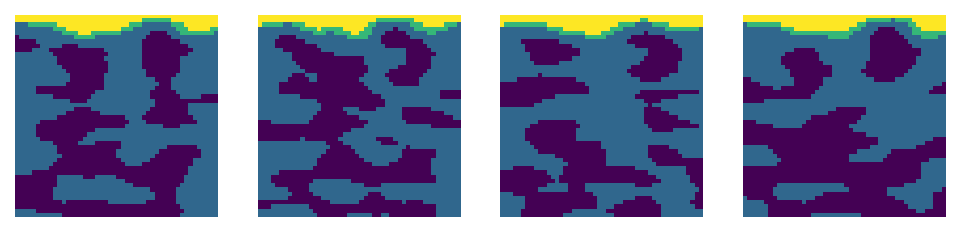

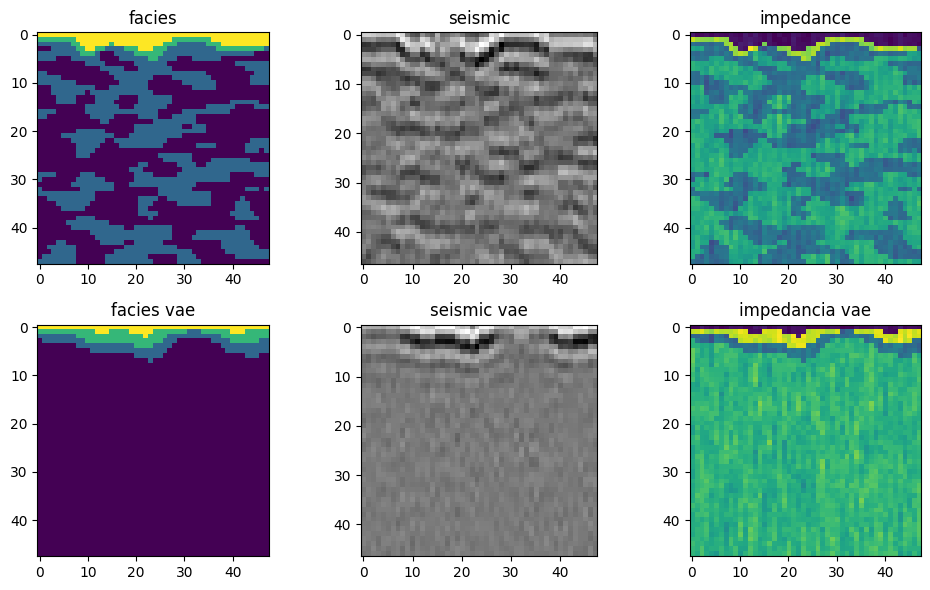

MSE model: [0.4418403 0.421875  0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.       ]
MSE seismic: [0.00195011 0.00182438 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  3


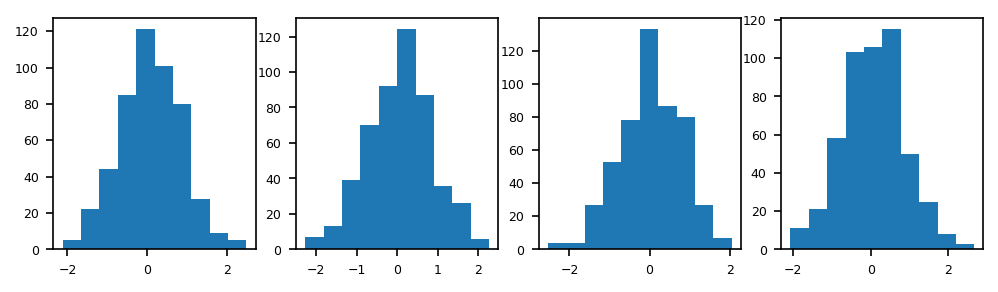

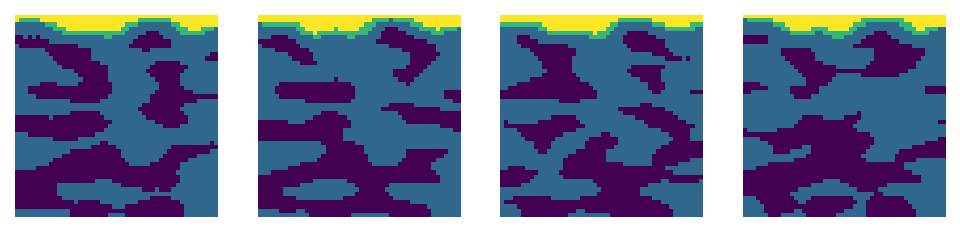

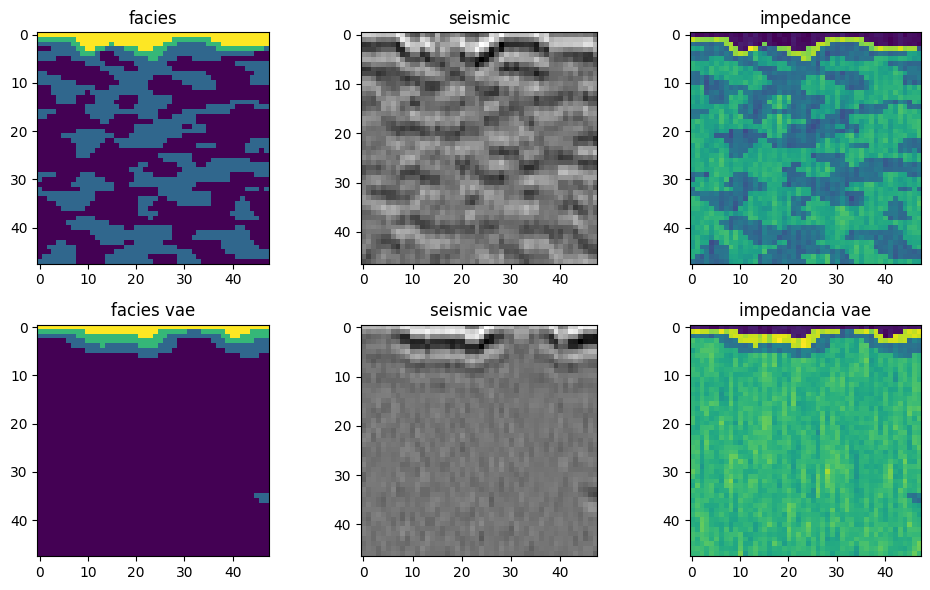

MSE model: [0.4418403 0.421875  0.4188368 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.       ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  4


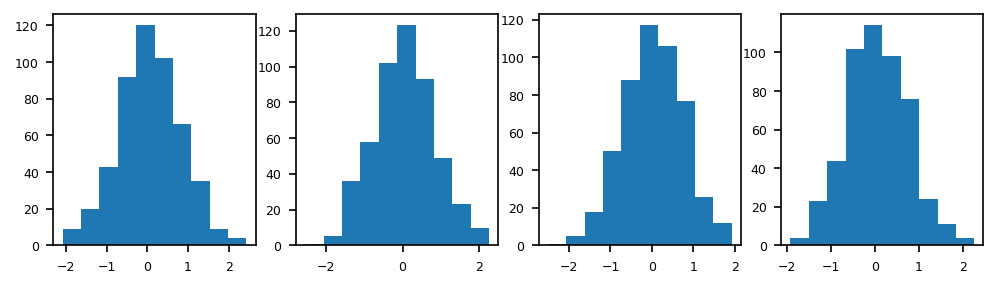

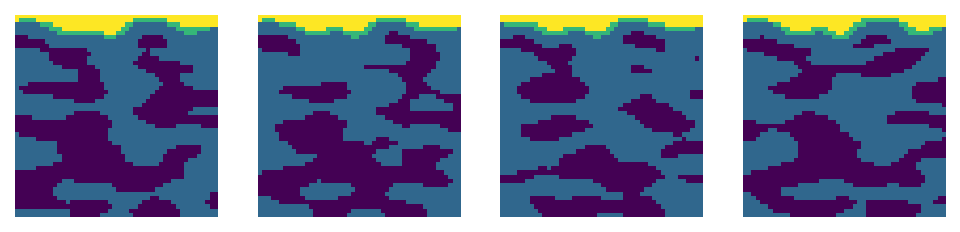

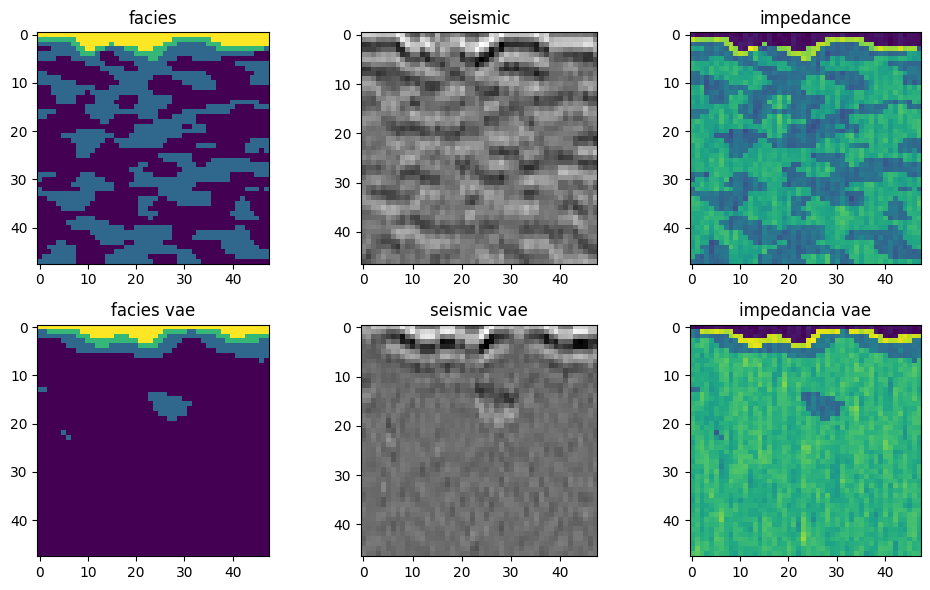

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  5


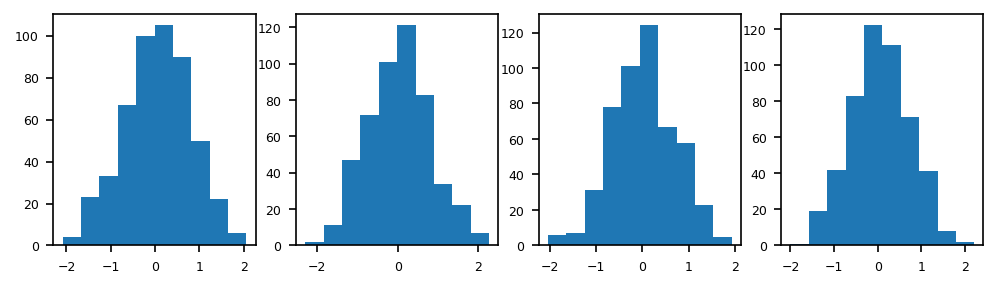

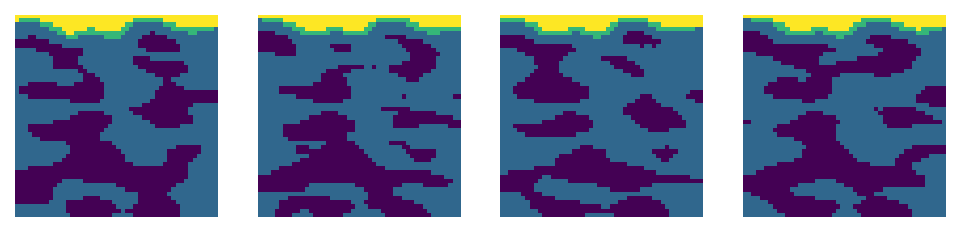

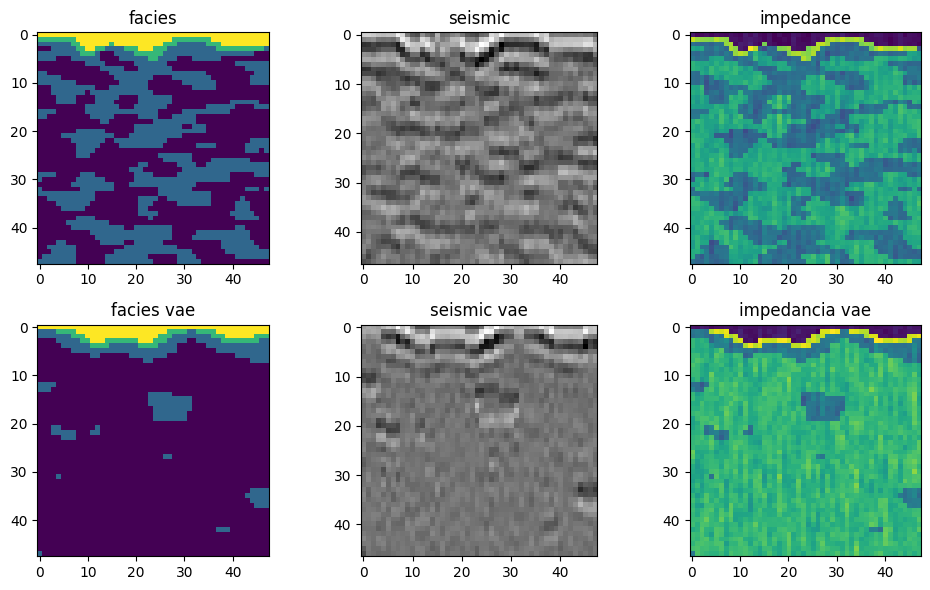

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  6


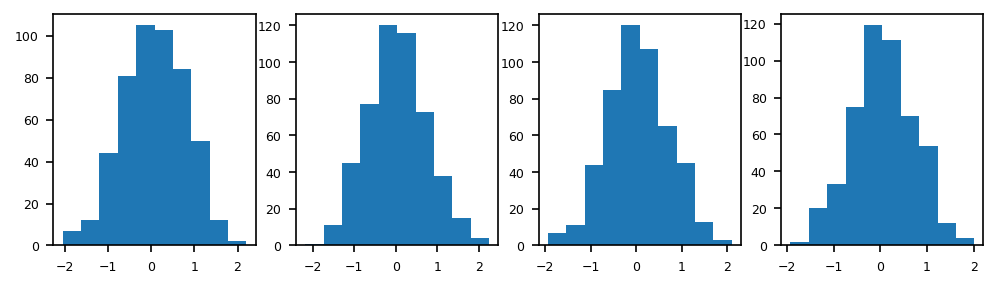

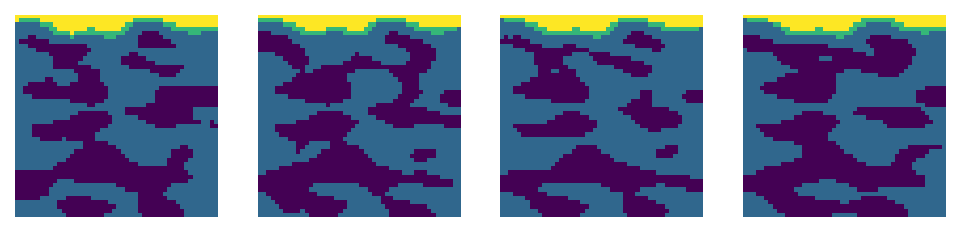

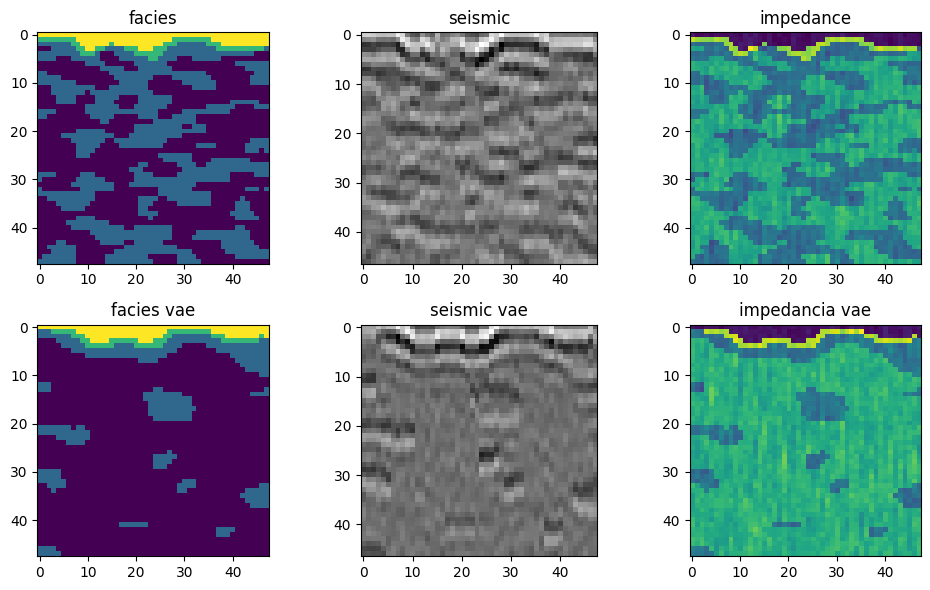

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  7


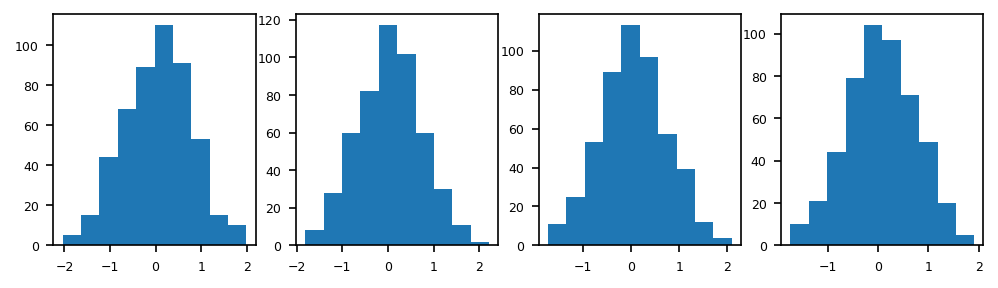

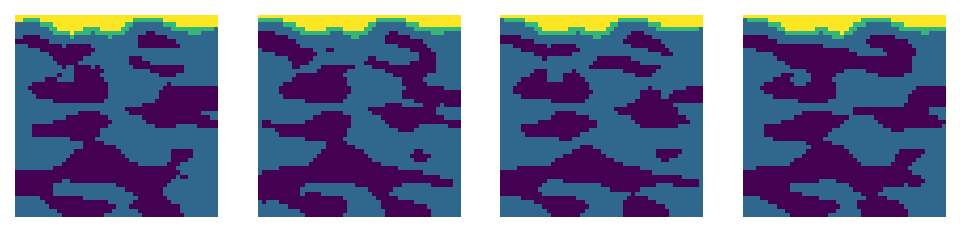

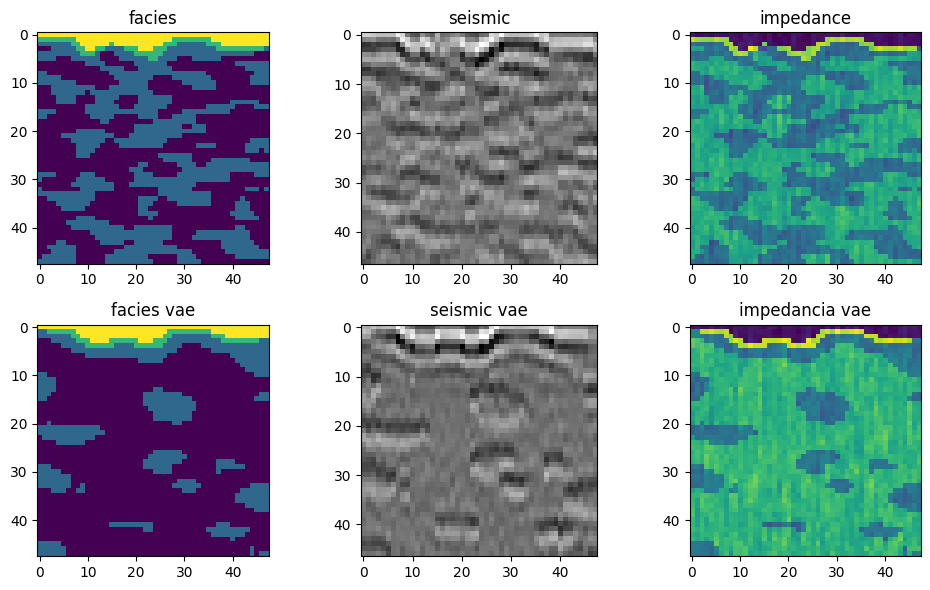

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  8


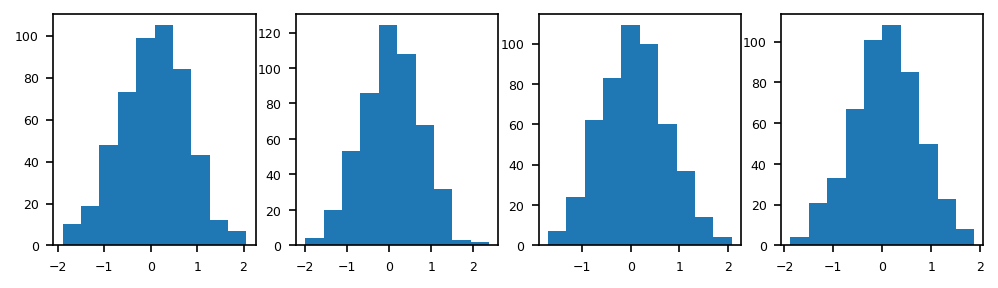

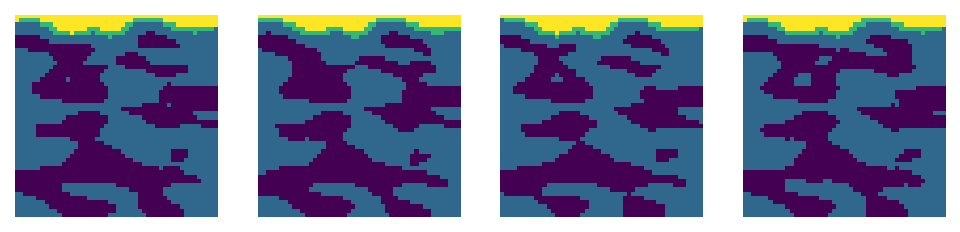

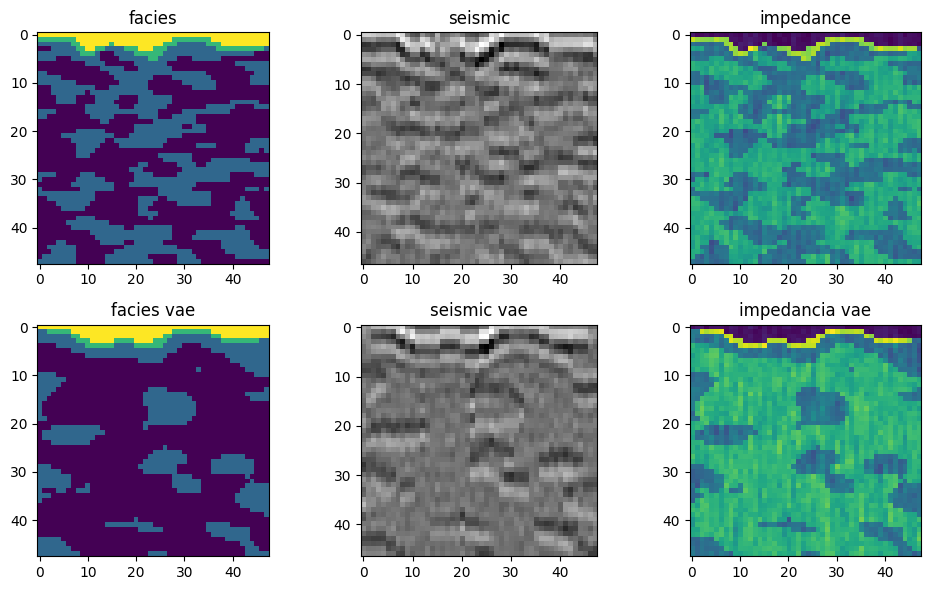

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  9


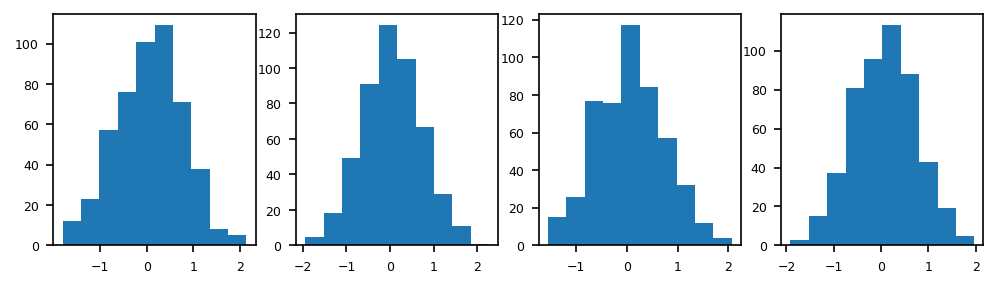

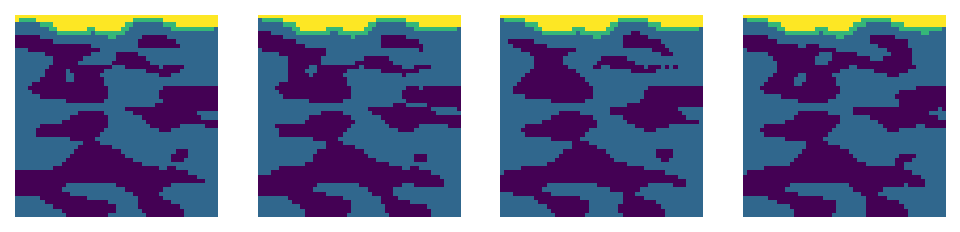

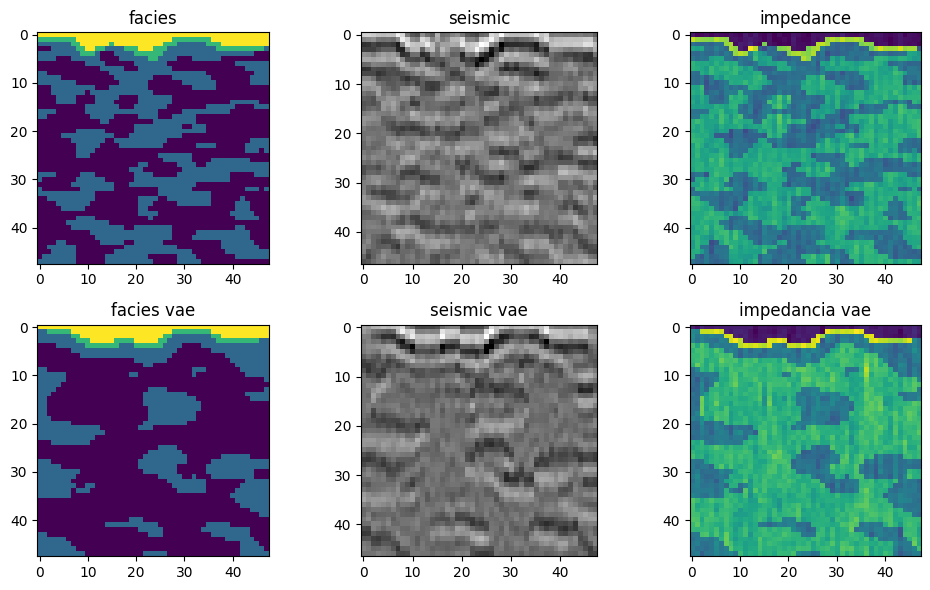

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  10


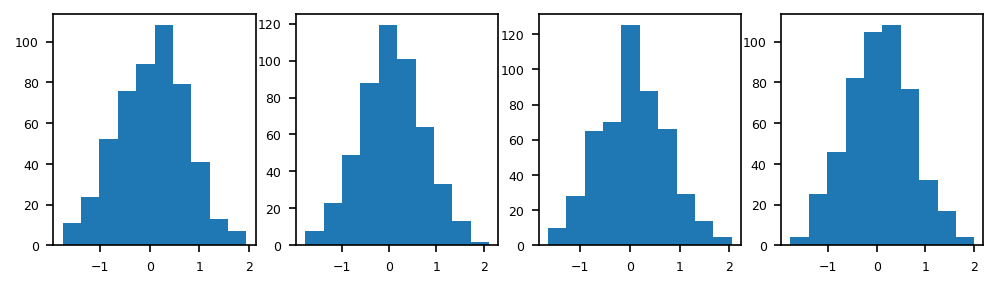

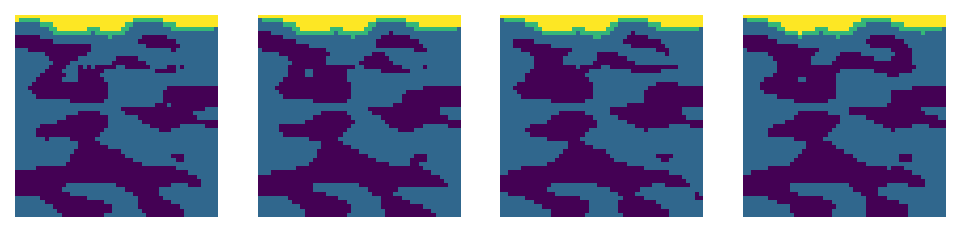

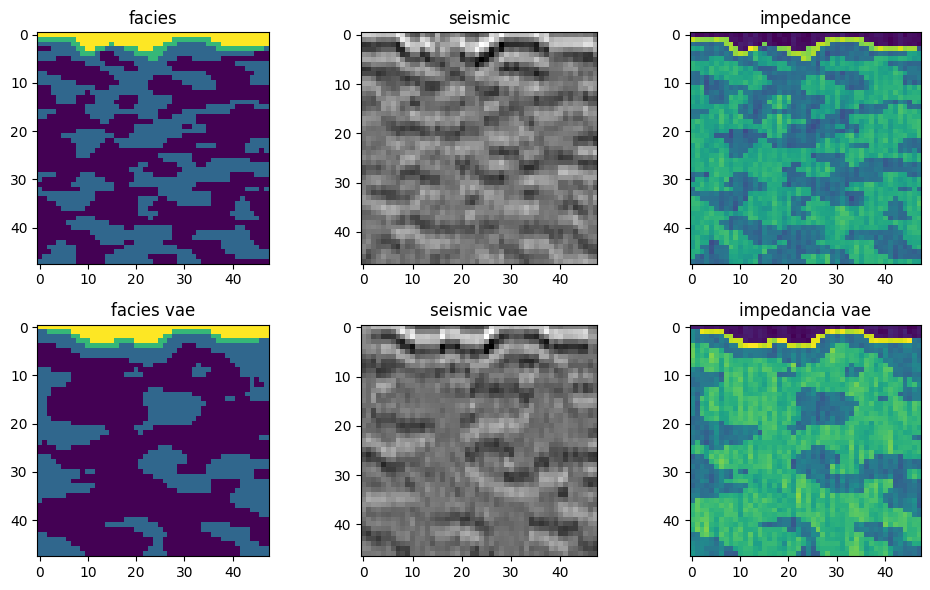

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  11


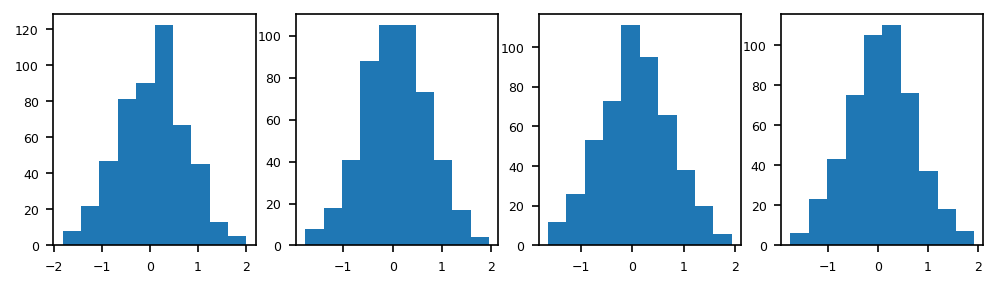

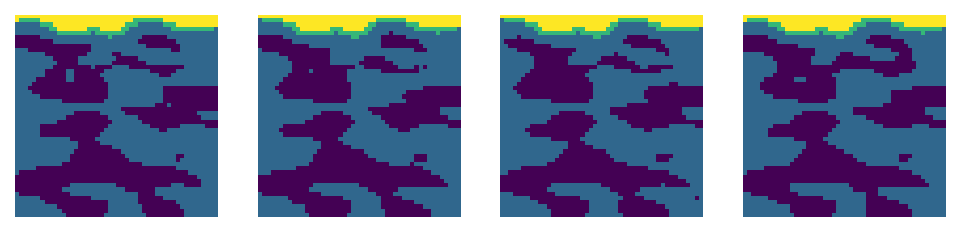

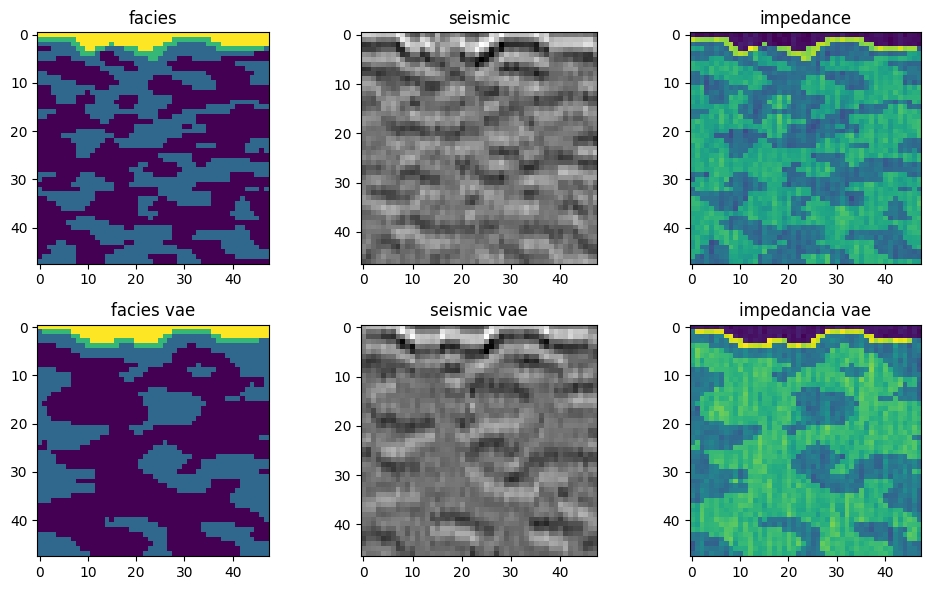

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  12


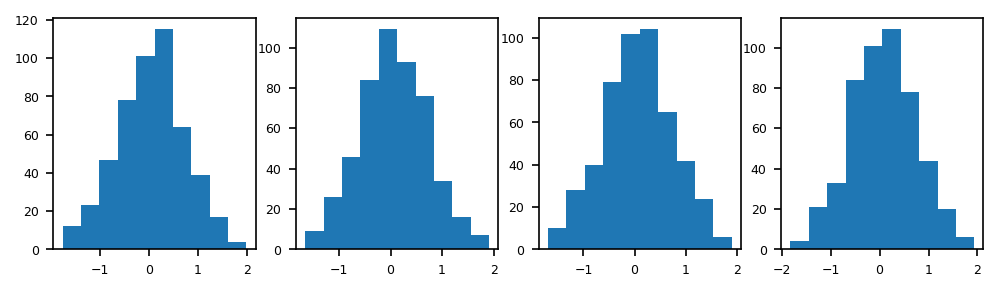

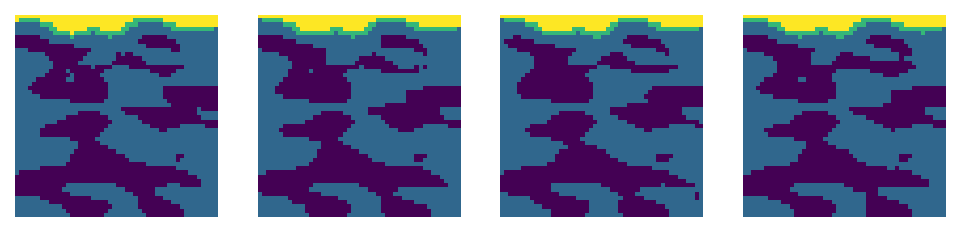

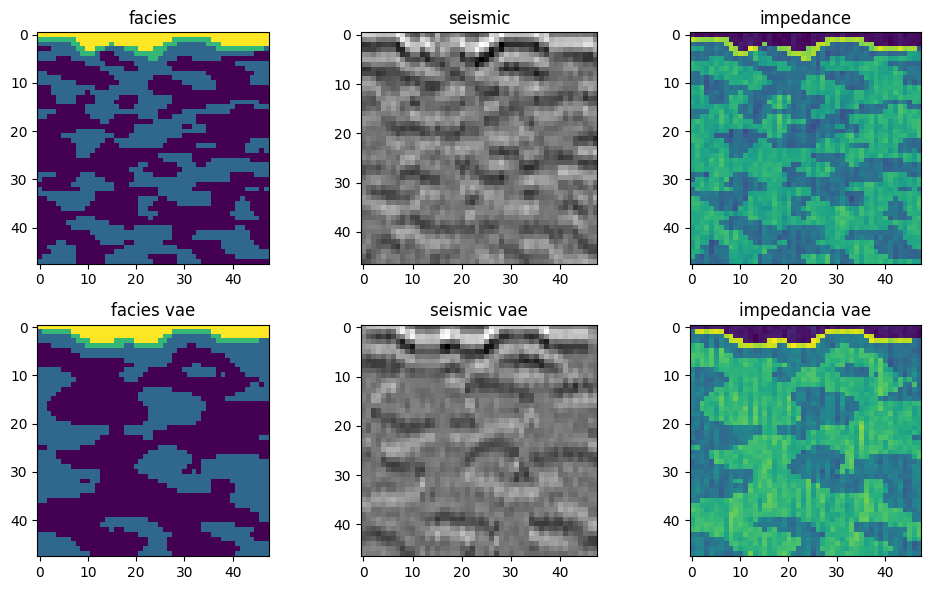

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  13


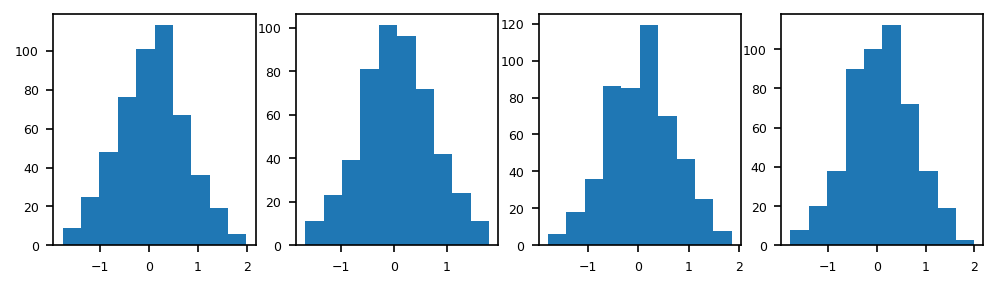

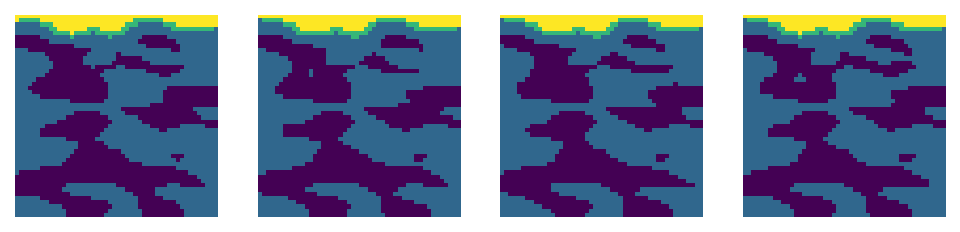

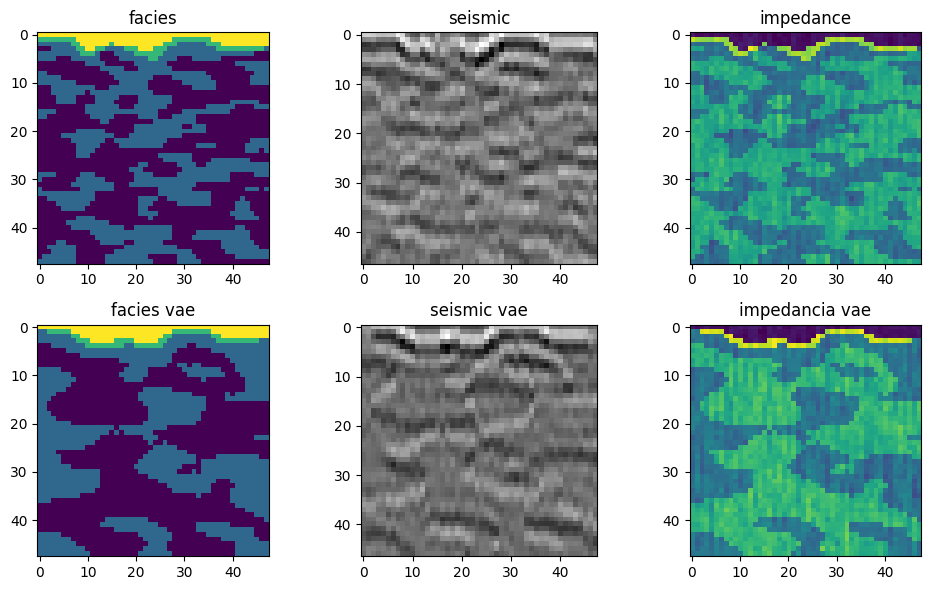

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.3125     0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.00075639 0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.01334704 0.         0.         0.         0.         0.
 0.         0.        ]
Update  14


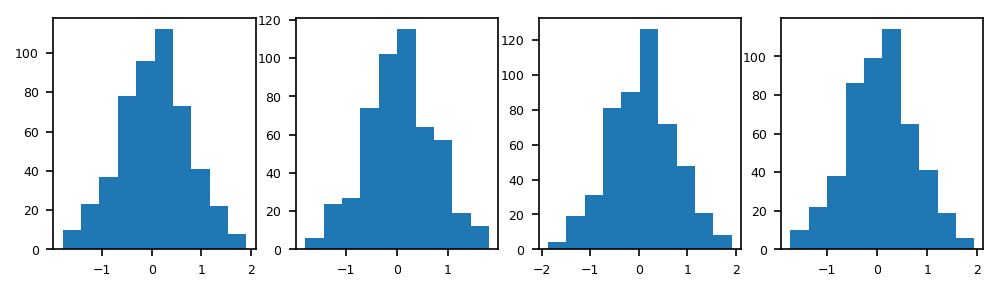

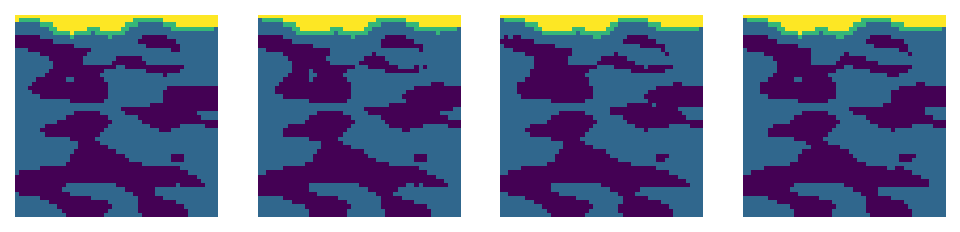

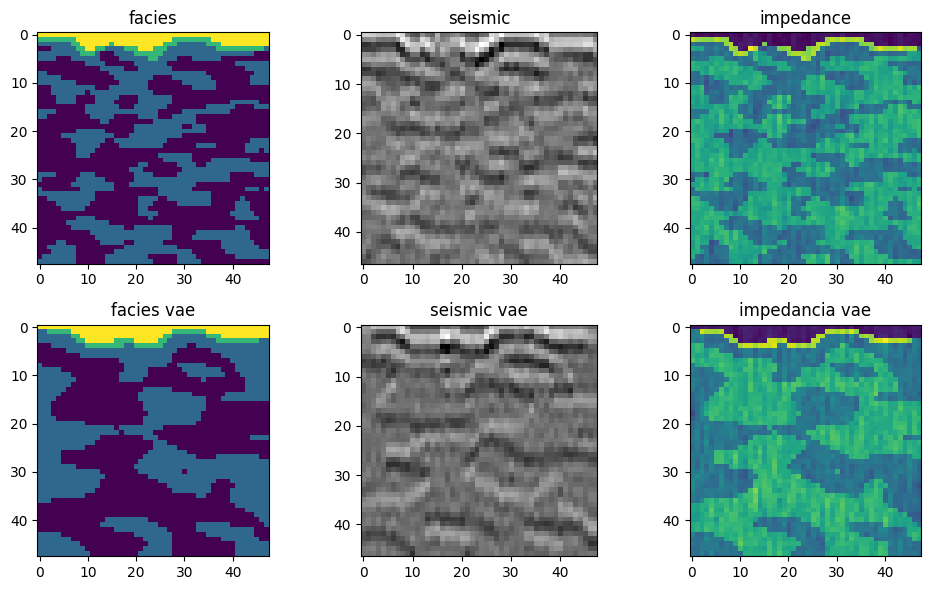

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.3125     0.3059896  0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.00075639 0.00072363 0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.01334704 0.01295686 0.         0.         0.         0.
 0.         0.        ]
Update  15


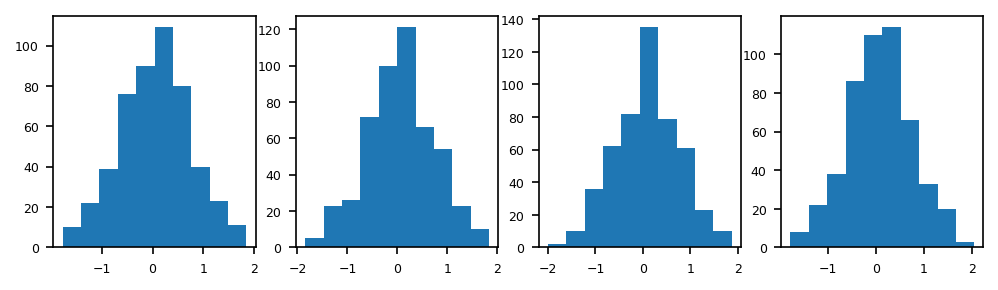

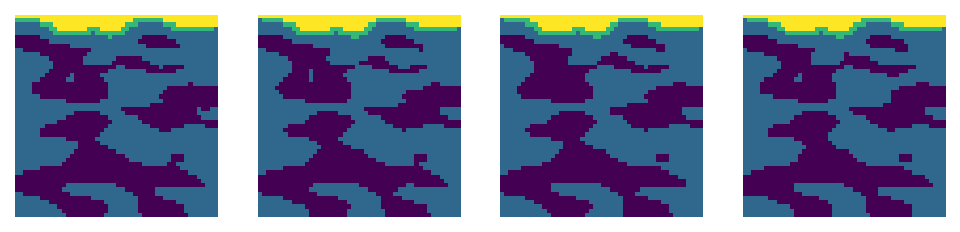

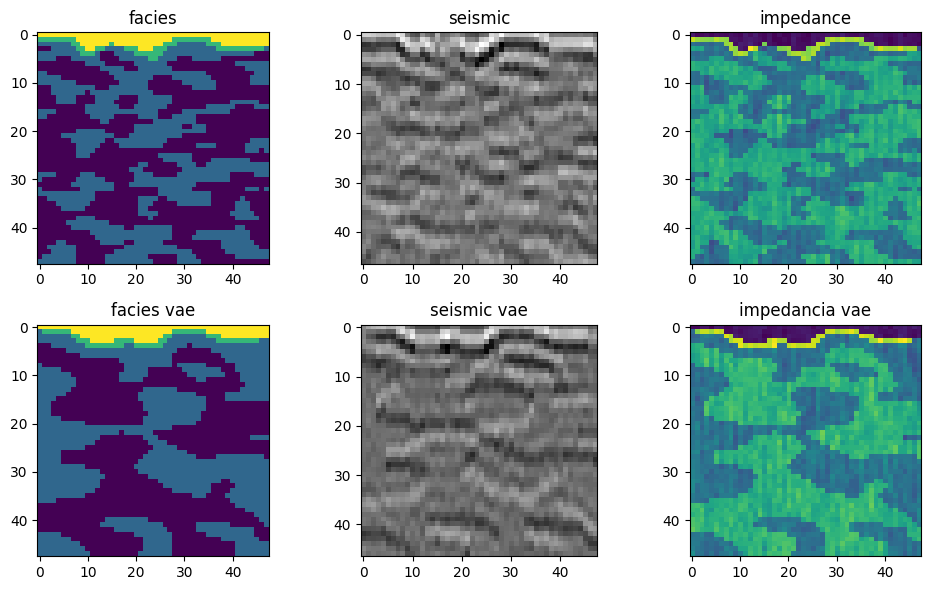

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.3125     0.3059896  0.30512154 0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.00075639 0.00072363 0.00071846 0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.01334704 0.01295686 0.01336956 0.         0.         0.
 0.         0.        ]
Update  16


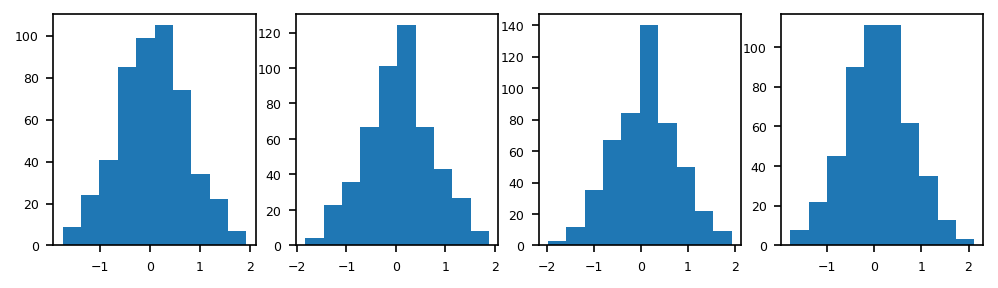

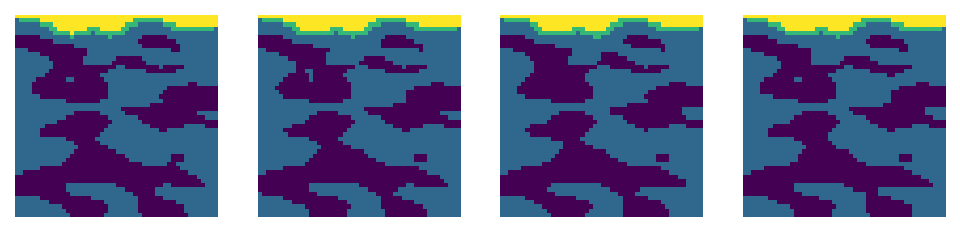

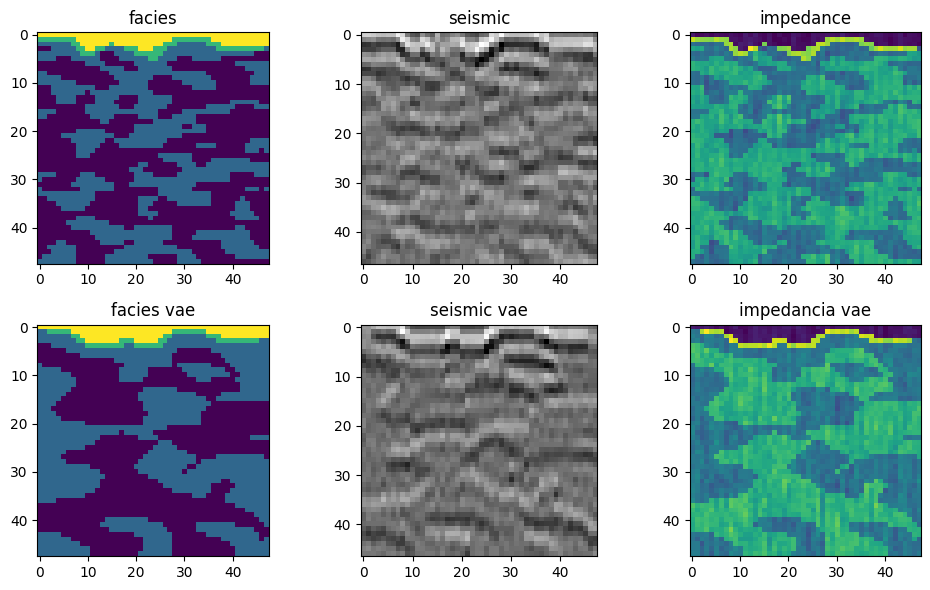

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.3125     0.3059896  0.30512154 0.30859375 0.         0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.00075639 0.00072363 0.00071846 0.00069577 0.         0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.01334704 0.01295686 0.01336956 0.01284077 0.         0.
 0.         0.        ]
Update  17


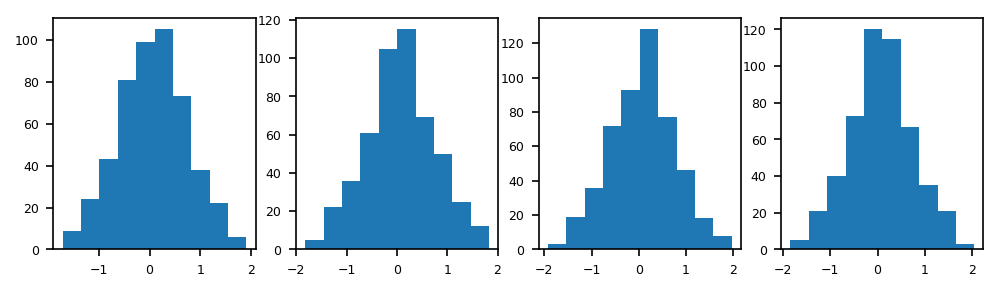

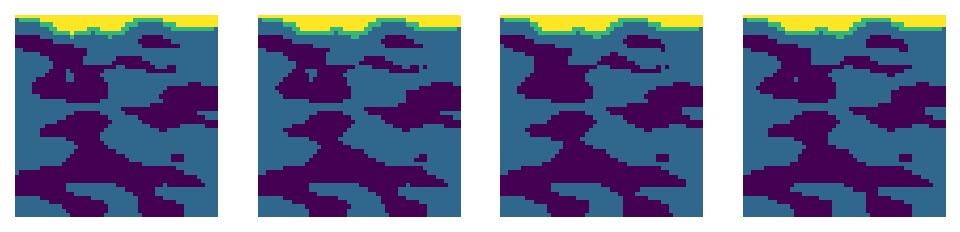

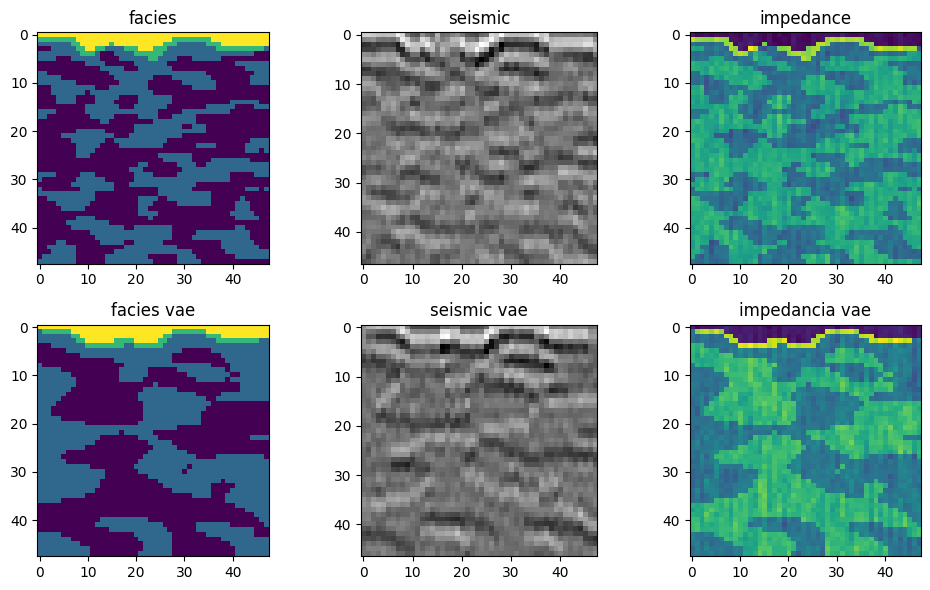

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.3125     0.3059896  0.30512154 0.30859375 0.3059896  0.
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.00075639 0.00072363 0.00071846 0.00069577 0.00069053 0.
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.01334704 0.01295686 0.01336956 0.01284077 0.01312661 0.
 0.         0.        ]
Update  18


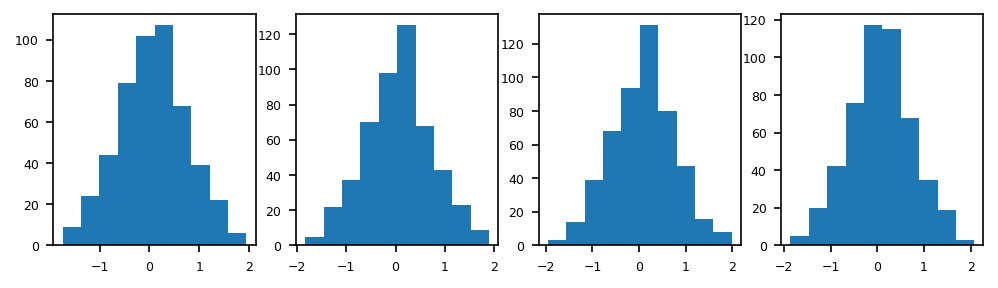

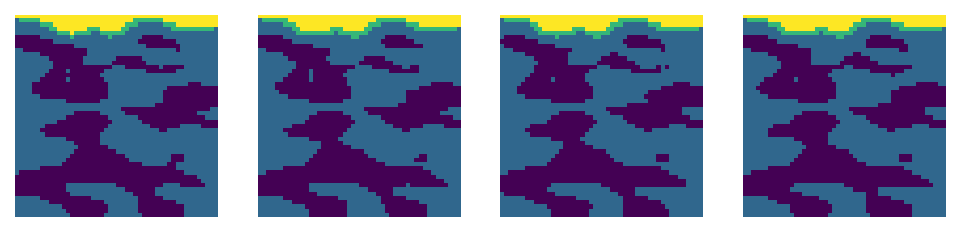

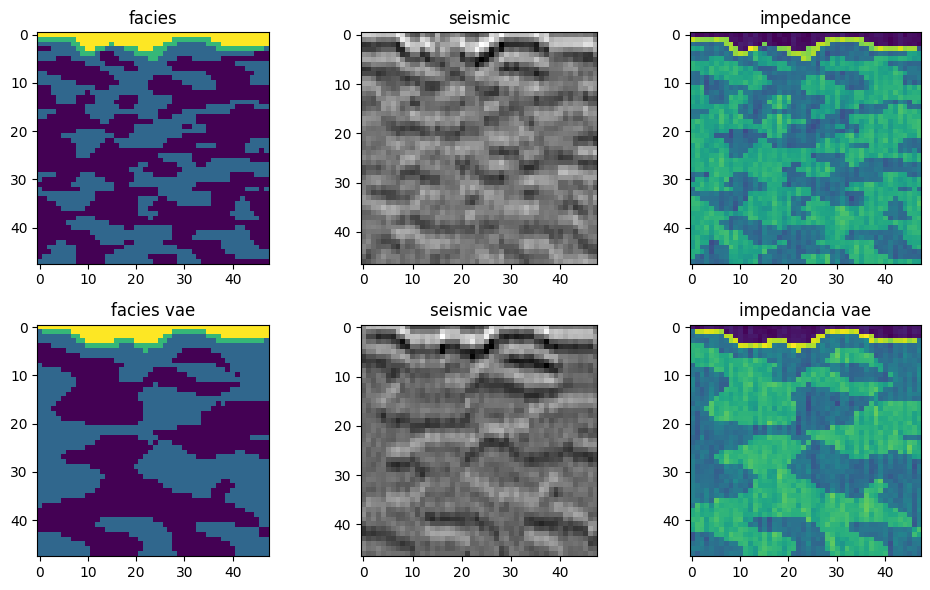

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.3125     0.3059896  0.30512154 0.30859375 0.3059896  0.3059896
 0.         0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.00075639 0.00072363 0.00071846 0.00069577 0.00069053 0.00065684
 0.         0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.01334704 0.01295686 0.01336956 0.01284077 0.01312661 0.01309151
 0.         0.        ]
Update  19


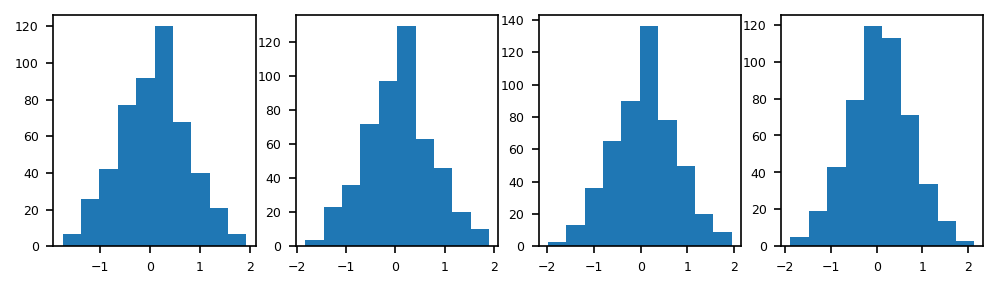

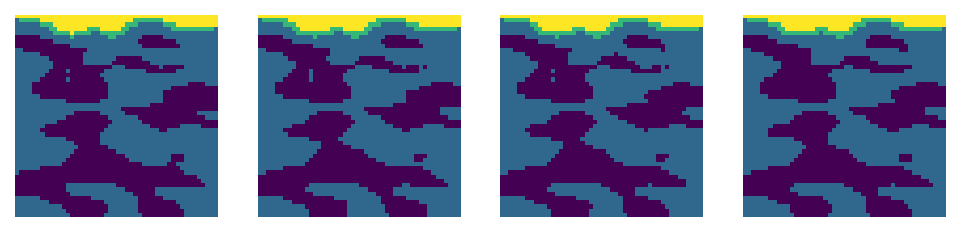

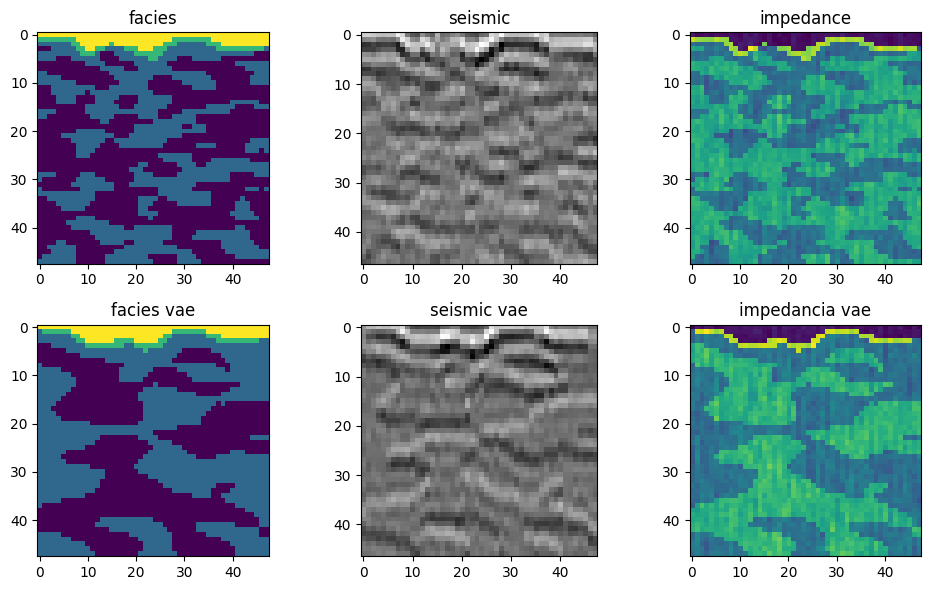

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.3125     0.3059896  0.30512154 0.30859375 0.3059896  0.3059896
 0.30729166 0.        ]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.00075639 0.00072363 0.00071846 0.00069577 0.00069053 0.00065684
 0.00066039 0.        ]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.01334704 0.01295686 0.01336956 0.01284077 0.01312661 0.01309151
 0.01332802 0.        ]
Update  20


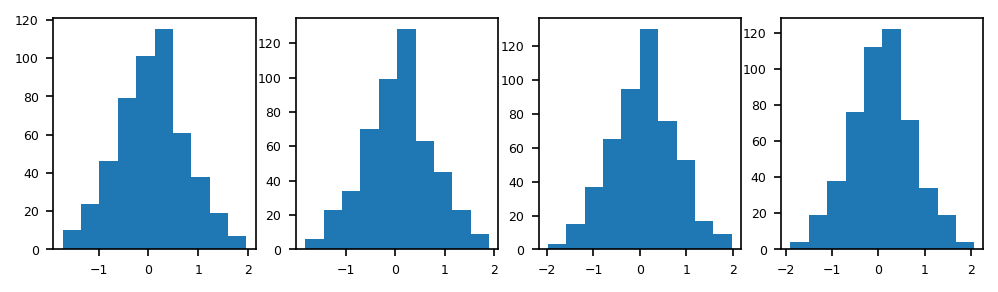

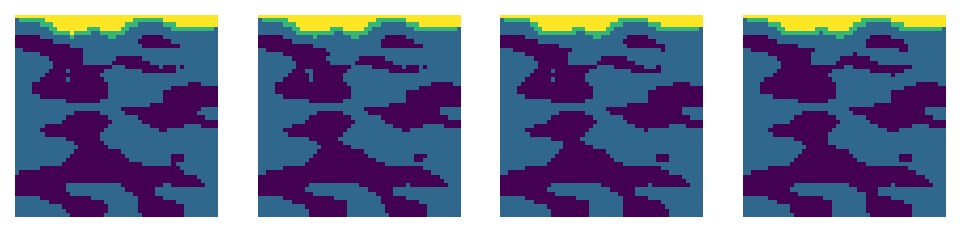

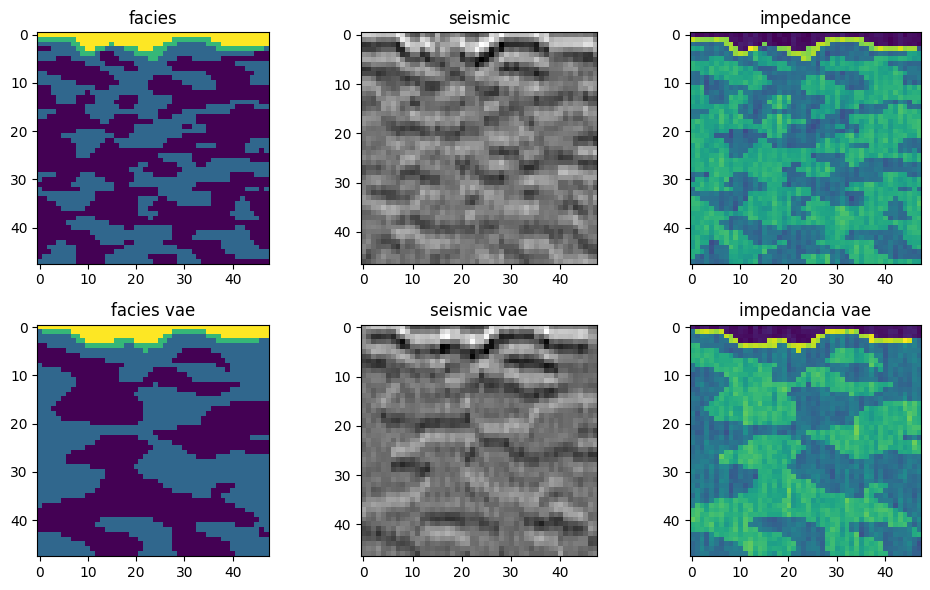

MSE model: [0.4418403  0.421875   0.4188368  0.40060765 0.3949653  0.38802084
 0.3658854  0.3467882  0.3407118  0.33680555 0.3263889  0.31293404
 0.3125     0.3059896  0.30512154 0.30859375 0.3059896  0.3059896
 0.30729166 0.30685765]
MSE seismic: [0.00195011 0.00182438 0.00156477 0.00124782 0.00115703 0.00108751
 0.00106163 0.00100479 0.00089795 0.00085703 0.00080861 0.00078299
 0.00075639 0.00072363 0.00071846 0.00069577 0.00069053 0.00065684
 0.00066039 0.00068014]
MSE impedance: [0.02491453 0.02381578 0.02193049 0.01809124 0.0168106  0.01577861
 0.01508613 0.01445369 0.01405834 0.01367031 0.01354649 0.0132772
 0.01334704 0.01295686 0.01336956 0.01284077 0.01312661 0.01309151
 0.01332802 0.01308348]
Total time(s):  800.1180114746094


In [319]:
from IPython.core.debugger import set_trace

import time

Na = 20
Ne = 400
cut_factor = 1


alpha = tf.constant(20, dtype=tf.float32)

G = tf.constant(acoustic_foward_matrix(wavelet,I), np.float32)

ms = tf.Variable(tf.random.normal(shape=[Ne, vae.latent_dim])*cut_factor)
seis = tf.Variable(tf.zeros([Ne, G.shape[0]*G.shape[1]]))
imps =  tf.Variable(tf.zeros([Ne, (G.shape[0]+1) * G.shape[1]]))
esmda_loss = tf.Variable(tf.zeros([Na]))
esmda_seismic_loss = tf.Variable(tf.zeros([Na]))
esmda_imp_loss = tf.Variable(tf.zeros([Na]))
### Sampling the reference model using the decoder
#rn = tf.random.normal(shape=[2, vae.latent_dim, vae.latent_dim, 1], mean=0, stddev=1)
#facies = np.around( vae.decoder.predict(rn)*3)[0]
#mr = tf.constant(facies.reshape(1,n,n,1), dtype=tf.float32)

### Reference model using MC
mr = tf.constant(ss.reshape(1,n,n,1), dtype=tf.float32)

seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(mr.numpy().reshape(n,n),PRIOR,G.numpy(), v_fact)
seis_exp = tf.constant(seis_exp_tmp.reshape(-1), dtype=tf.float32)
imp_exp = tf.constant(imp_exp_tmp.reshape(-1), dtype=tf.float32)

noise = np.random.randn((I-1)*J)
noise = noise/np.std(noise)
std_noise = np.std(seis_exp)/np.sqrt(signal2noise)
noise = noise*std_noise
#seis_exp = seis_exp + noise

fig, axs = plt.subplots(1,3)
fig.set_dpi(120)
axs[0].imshow(mr.numpy().reshape(n,n))
axs[1].imshow(seis_exp.numpy().reshape(n-1,n), cmap='gray')
axs[2].imshow(imp_exp.numpy().reshape(n,n))
plt.margins(0,0)
plt.show()

C_d = std_noise**2*tf.eye(seis_exp.shape[0])

start_time = time.time()


# Ensemble initialization

for e in range(0,Ne):
    lat = ms[e:e+1].numpy().reshape(1,vae.latent_dim)
    facies = tf.Variable(vae.decode(lat))
    seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(np.array(facies.numpy().reshape(n,n)),PRIOR,G.numpy(), v_fact)
    seis[e].assign(seis_exp_tmp.reshape(-1))
    imps[e].assign(imp_exp_tmp.reshape(-1))

print('Initial ensemble...')
plt_ensamble_dense(ms.numpy().reshape(Ne,vae.latent_dim))


mean = tf.Variable(tf.reduce_mean(ms, axis=0))

# Ensemble update
start_time = time.time()
# For update (u) in number of updates (updts)
for u in range (0,Na):
    print('Update ', u+1)
    mean.assign(tf.reduce_mean(ms, 0))
    
    data_diff = seis.numpy() - np.tile(seis.numpy().mean(axis=0), (Ne,1) )
    model_diff = ms.numpy() - np.tile(ms.numpy().mean(axis=0), (Ne,1) )

    C_dd = tf.linalg.matmul(tf.transpose(data_diff), data_diff)/(Ne-1)
    C_md = tf.linalg.matmul(tf.transpose(model_diff), data_diff)/(Ne-1)
    
    d_tio = seis_exp + tf.math.sqrt(alpha)*tf.random.normal(seis_exp.shape)*std_noise    
    
    """
    fig, axs = plt.subplots(1,2, figsize=(10, 6))
    axs[0].imshow(seis_exp.numpy().reshape(n-1,n))
    axs[0].set_title('d')
    axs[1].imshow(d_tio.numpy().reshape(n-1,n))
    axs[1].set_title('d_tio')
    plt.show()
            
    fig, axs = plt.subplots(1,2,dpi=200)
    axs[0].set_title('Cdd')
    axs[1].set_title('Cmd')
    axs[0].imshow(C_dd[:100,:100])
    axs[1].imshow(C_md[:,:100])
    plt.show()
    """
    
    #K = tf.linalg.matmul(C_md, tf.linalg.pinv(C_dd + alpha*C_d, 0.001*tf.reduce_mean(tf.linalg.tensor_diag_part(C_d))))
    K = tf.linalg.matmul( C_md, tf.linalg.inv(C_dd + alpha*C_d) )   

    for e in range(0,Ne):     
        # MODIFIED! Cada componente do ensemble precisa de um ruido diferente. 
        d_tio = seis_exp + tf.math.sqrt(alpha)*tf.random.normal(seis_exp.shape)*std_noise

        dtio_dp = tf.reshape(d_tio - seis[e], [-1,1])
        Ksum = tf.reshape(tf.linalg.matmul(K,dtio_dp), ms[e].shape)

        ms[e].assign(ms[e] + Ksum)

        facies = tf.Variable(vae.decode(ms[e:e+1].numpy().reshape(1,vae.latent_dim)))

        seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(np.array(facies.numpy().reshape(n,n)),PRIOR,G.numpy(), v_fact)
        seis[e].assign(seis_exp_tmp.reshape(-1))
        imps[e].assign(imp_exp_tmp.reshape(-1))
        

    plt_ensamble_dense(ms.numpy().reshape(Ne,vae.latent_dim))

    mean_facies = tf.reduce_mean(vae.decode(ms.numpy().reshape(Ne, vae.latent_dim)), axis=0)

    facies_es = tf.reshape(mean_facies, [n,n])
    sismica_es, imp_es = facies_forward_model_2D(facies_es.numpy(),PRIOR,G.numpy(), v_fact)

    fig, axs = plt.subplots(2,3, figsize=(10, 6))
    axs[0,0].set_title('facies')
    axs[0,1].set_title('seismic')
    axs[0,2].set_title('impedance')
    axs[1,0].set_title('facies vae')
    axs[1,1].set_title('seismic vae')
    axs[1,2].set_title('impedancia vae')
    
    axs[0,0].imshow(tf.reshape(mr, [n,n]))
    axs[0,1].imshow(tf.reshape(seis_exp,[n-1,n]), cmap='gray')
    axs[0,2].imshow(imp_exp.numpy().reshape(n,n))
    axs[1,0].imshow(facies_es.numpy().reshape(n,n))
    axs[1,1].imshow(sismica_es.reshape(n-1,n), cmap='gray')
    axs[1,2].imshow(imp_es.reshape(n,n))
    fig.tight_layout()
    plt.show()
    plt.close()
    mse_model = tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(facies_es,-1), tf.expand_dims(tf.squeeze(mr),-1)))
    mse_seis = tf.reduce_mean(tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(sismica_es.reshape(n-1,n),-1), tf.expand_dims(tf.reshape(seis_exp,[n-1,n]),-1))))
    mse_imp = tf.reduce_mean(tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(imp_es.reshape(n,n),-1), tf.expand_dims(tf.reshape(imp_exp,[n,n]),-1))))
    esmda_loss[u].assign(mse_model)
    esmda_seismic_loss[u].assign(mse_seis)
    esmda_imp_loss[u].assign(mse_imp)
    print('MSE model:', esmda_loss.numpy())
    print('MSE seismic:', esmda_seismic_loss.numpy())
    print('MSE impedance:', esmda_imp_loss.numpy())

run_time = time.time() - start_time
print('Total time(s): ', run_time)

run_config = {
  "Na": Na,
  "Ne": Ne,
  "m_loss": esmda_loss.numpy().tolist(),
  "d_obs_loss": esmda_seismic_loss.numpy().tolist(),
  "dimp_obs_loss": esmda_imp_loss.numpy().tolist(),
  "reference": [
    {"facies": tf.reshape(mr, [n,n]).numpy().tolist()},
    {"seismic": tf.reshape(seis_exp,[n-1,n]).numpy().tolist()},
    {"impedance": tf.reshape(imp_exp,[n,n]).numpy().tolist()}
  ],
  "posterior": [
    {"facies": facies_es.numpy().reshape(n,n).tolist()},
    {"seismic": sismica_es.reshape(n-1,n).tolist()},
    {"impedance": imp_es.reshape(n,n).tolist()}
  ],
  "run_time": run_time
}

file_name = "vae_" + time.strftime("%Y%m%d_%H%M%S") + ".json"
with open(file_name, "w") as outfile:
    outfile.write(json.dumps(run_config, indent=4))


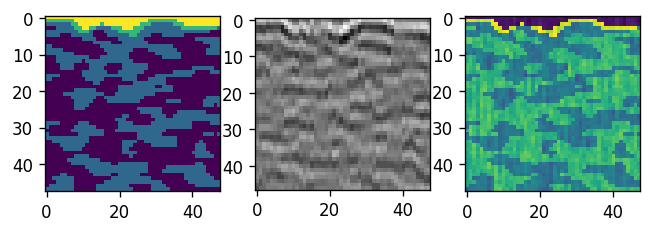

Initial ensemble...


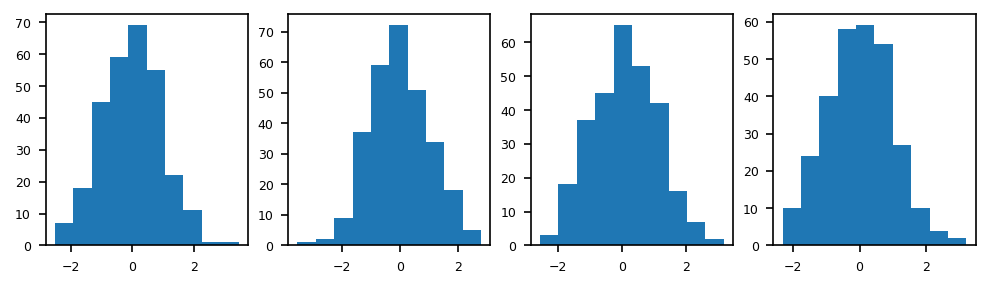

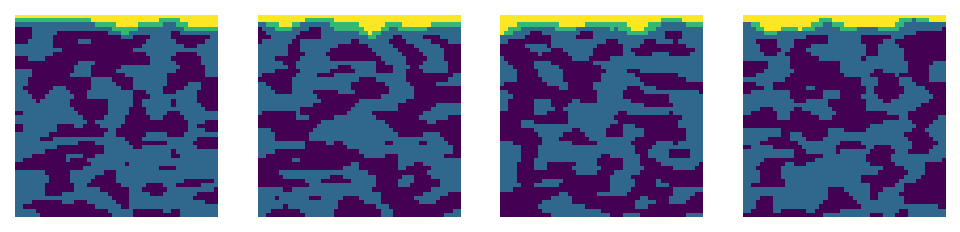

Update  1


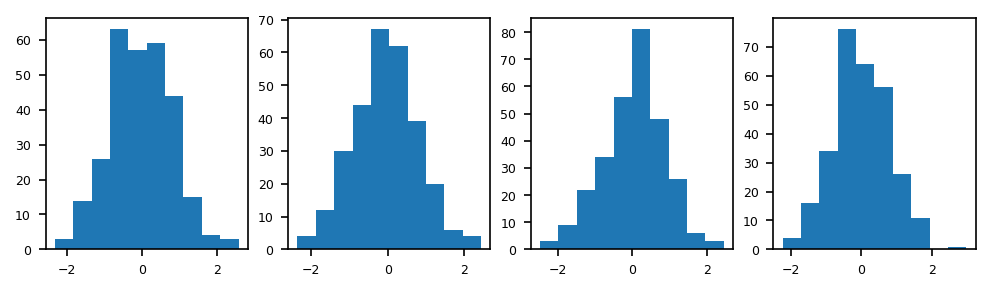

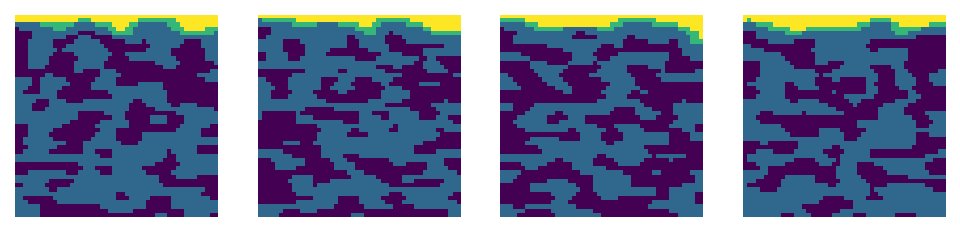

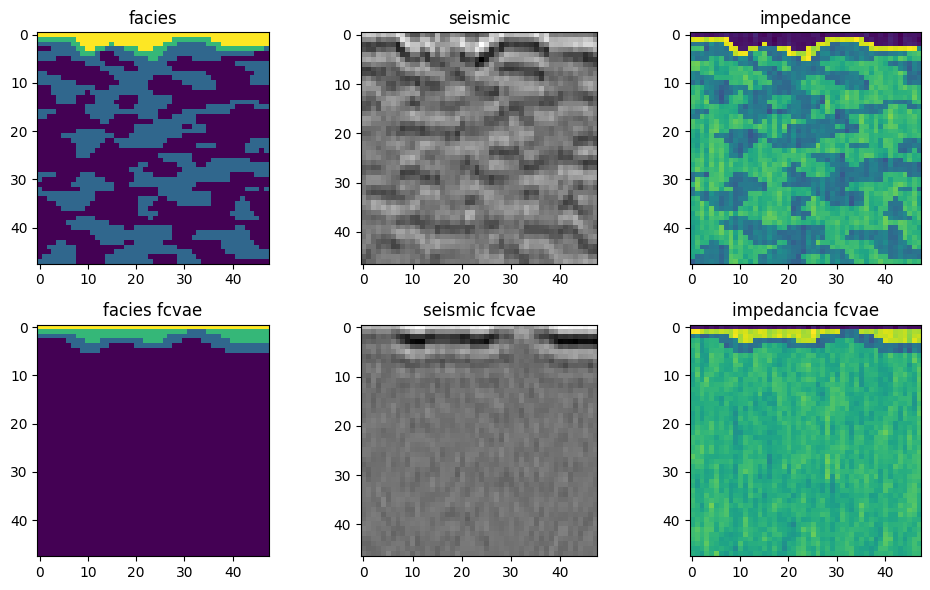

MSE model: [0.4375 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
MSE seismic: [0.00195185 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  2


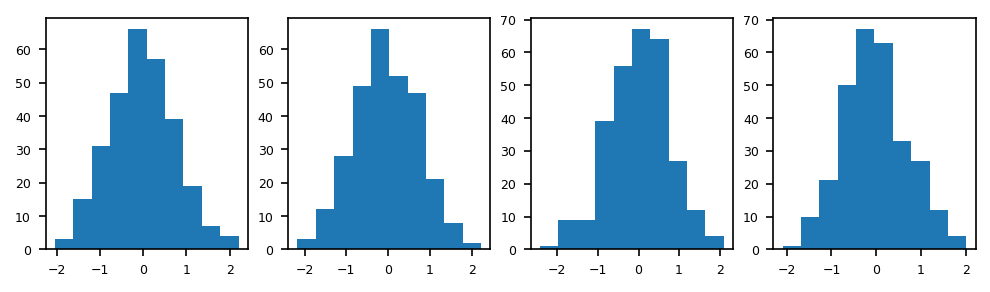

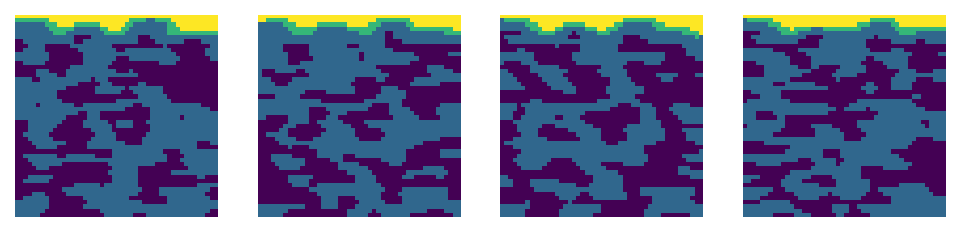

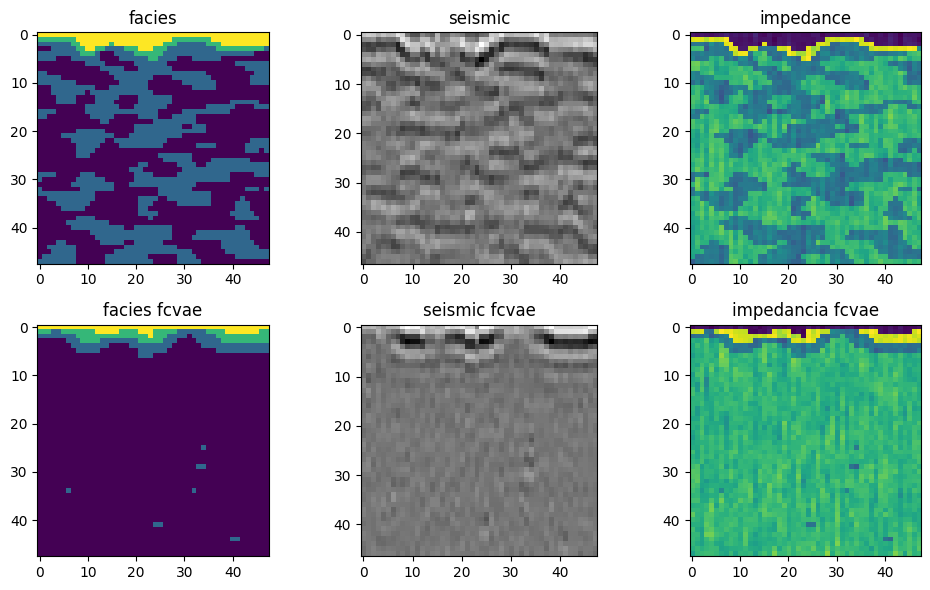

MSE model: [0.4375     0.41927084 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  3


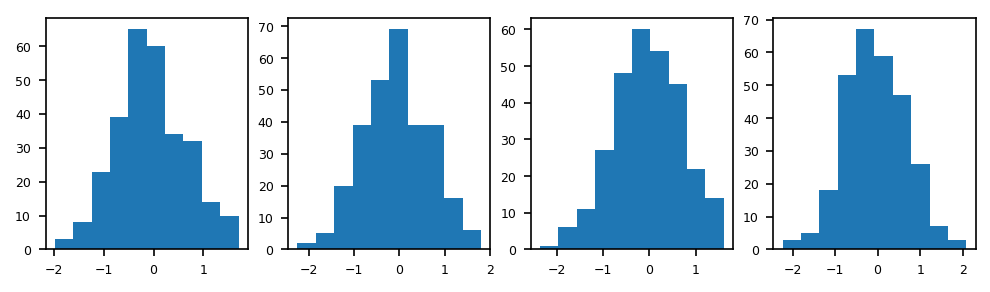

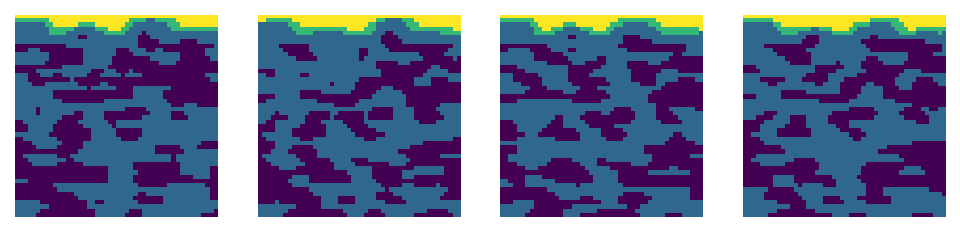

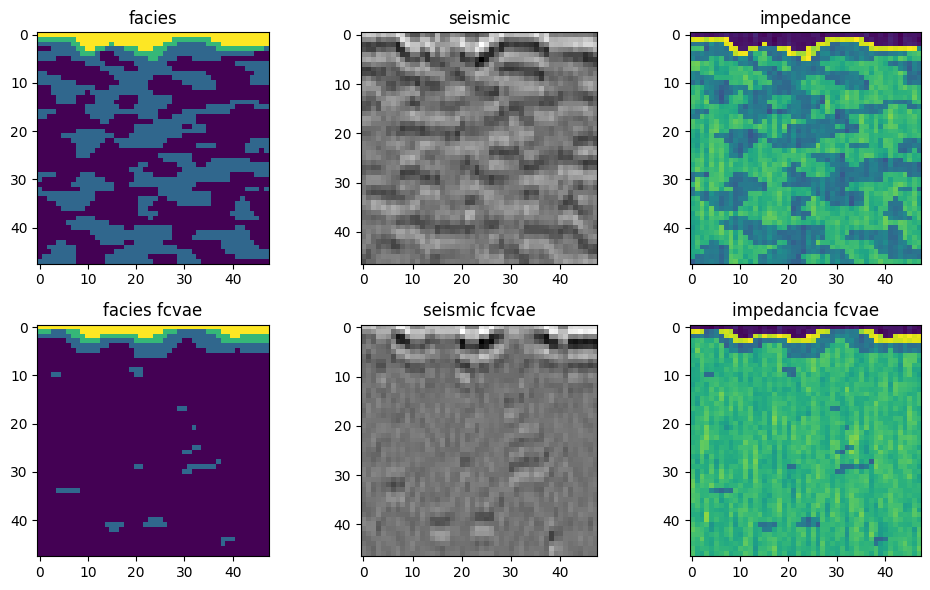

MSE model: [0.4375     0.41927084 0.39019096 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  4


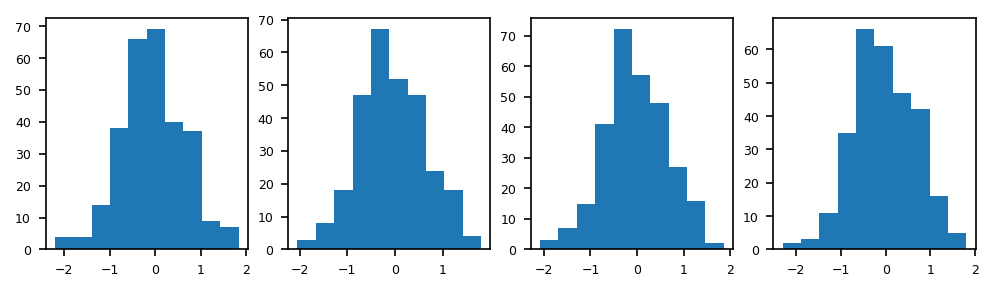

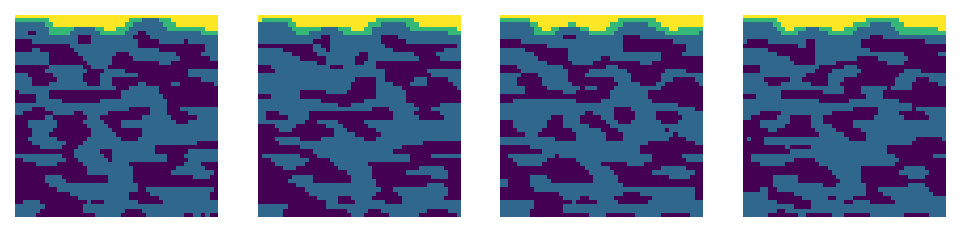

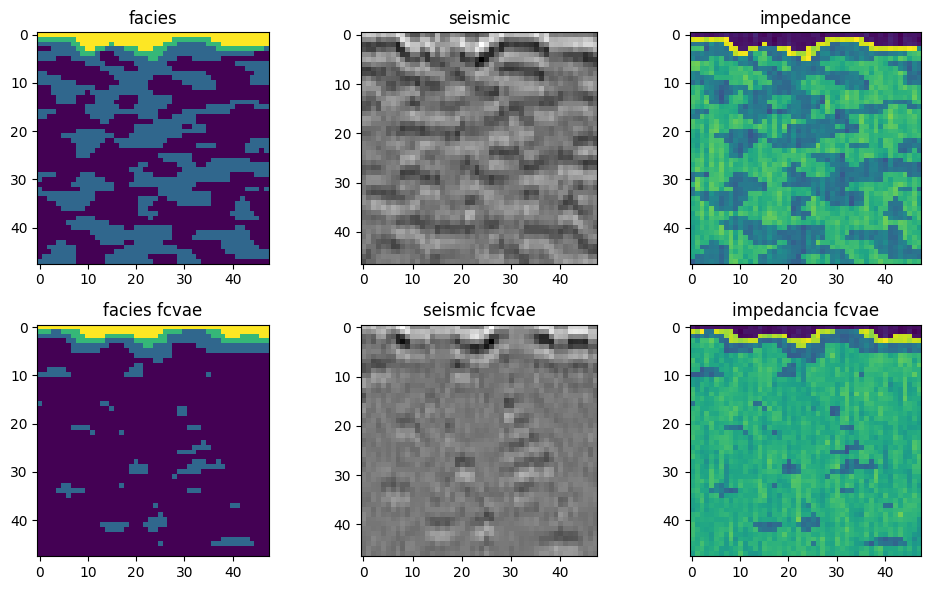

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  5


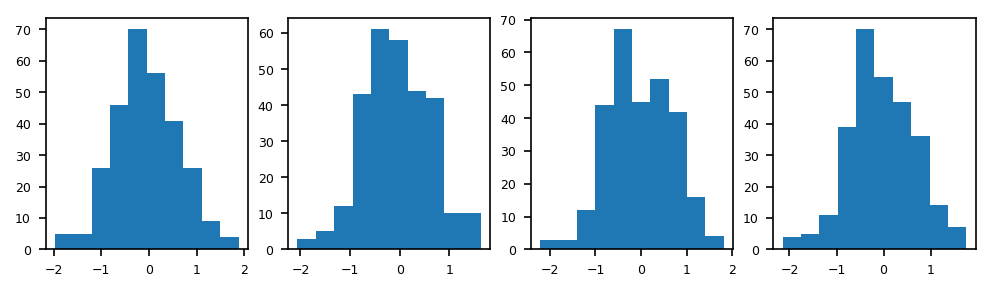

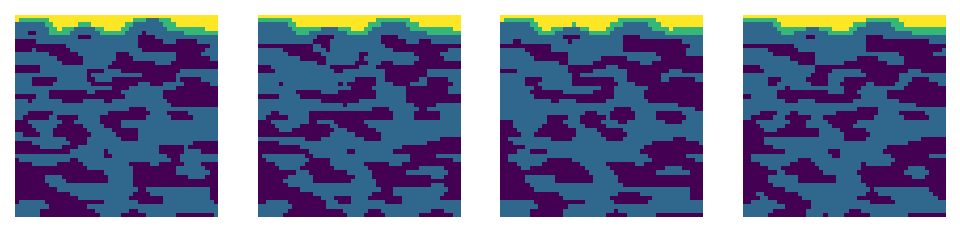

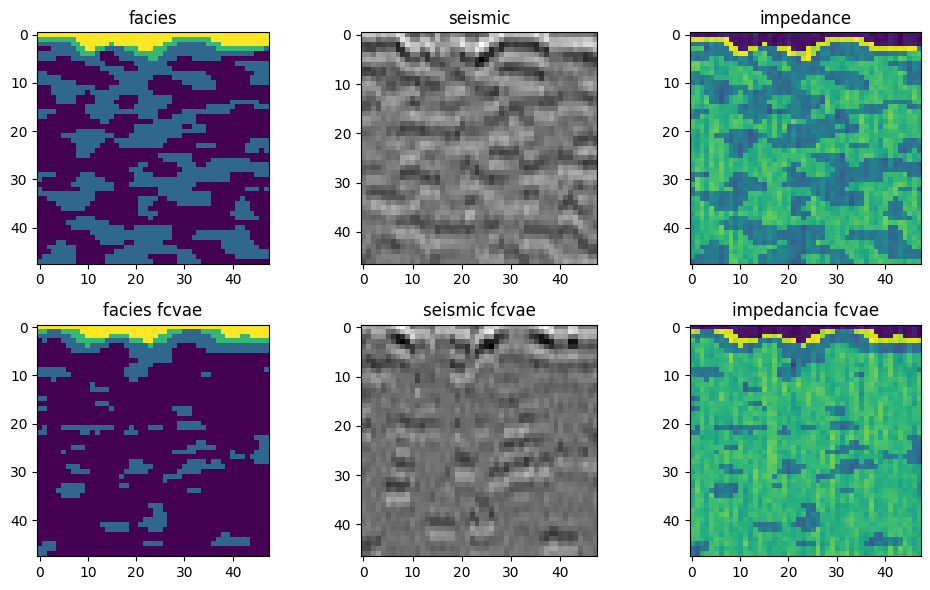

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  6


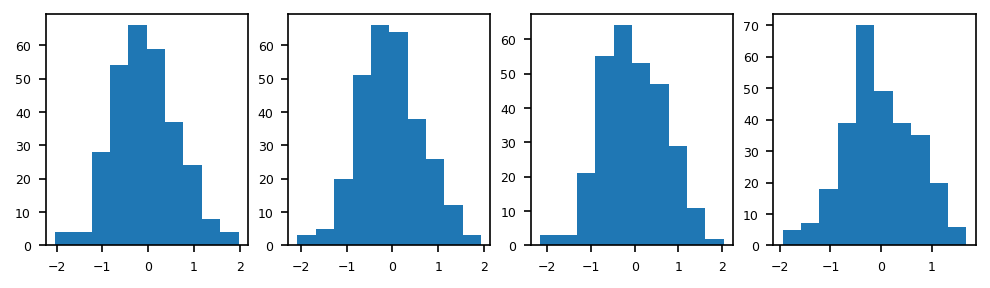

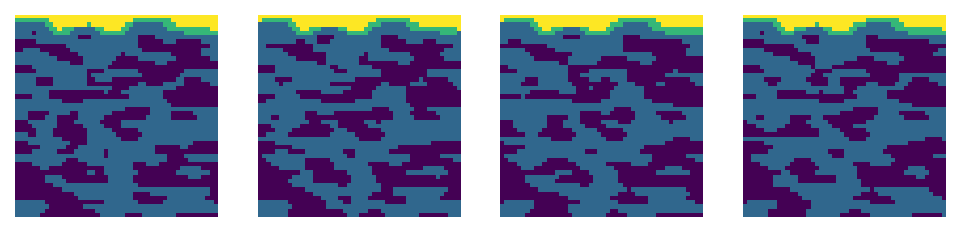

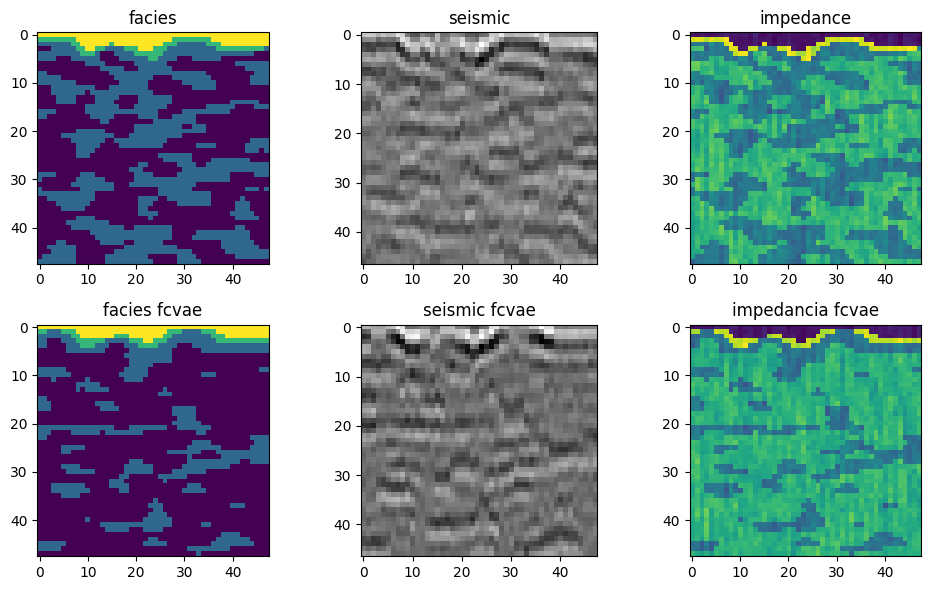

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  7


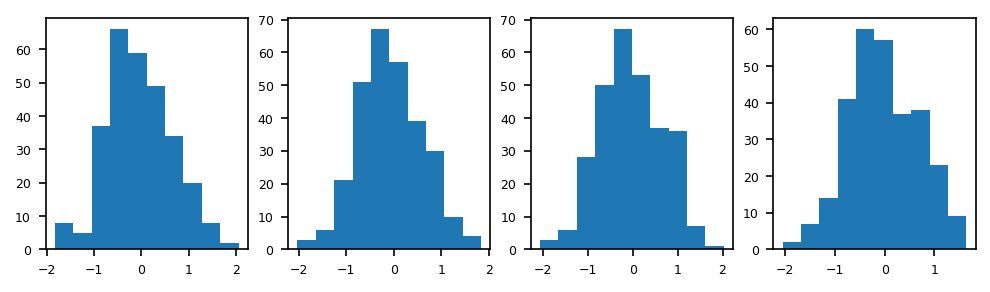

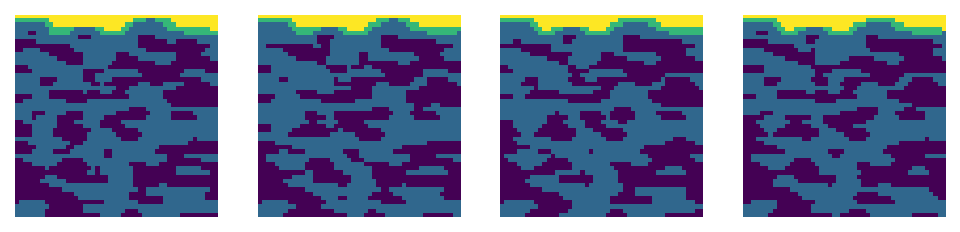

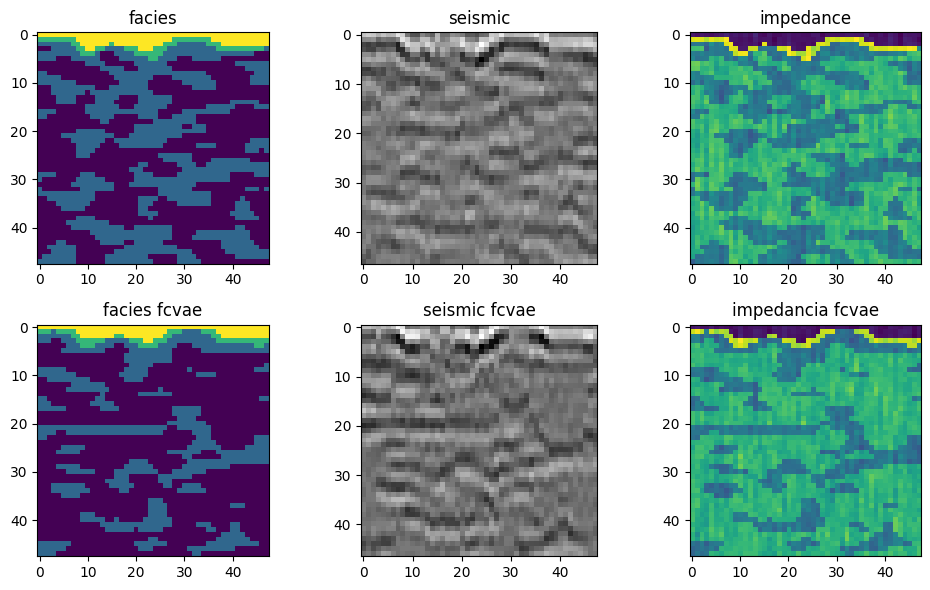

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  8


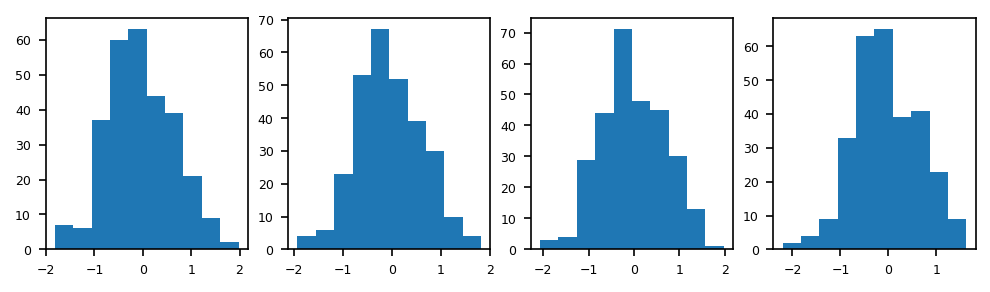

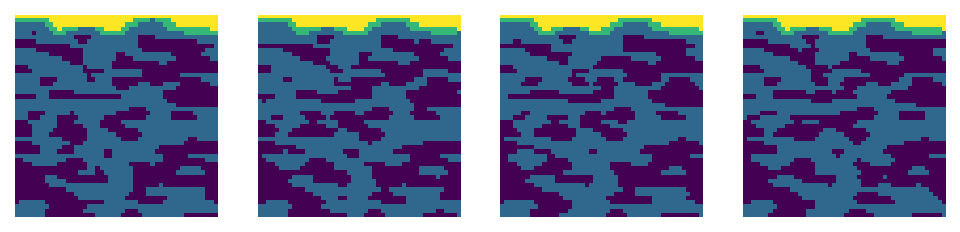

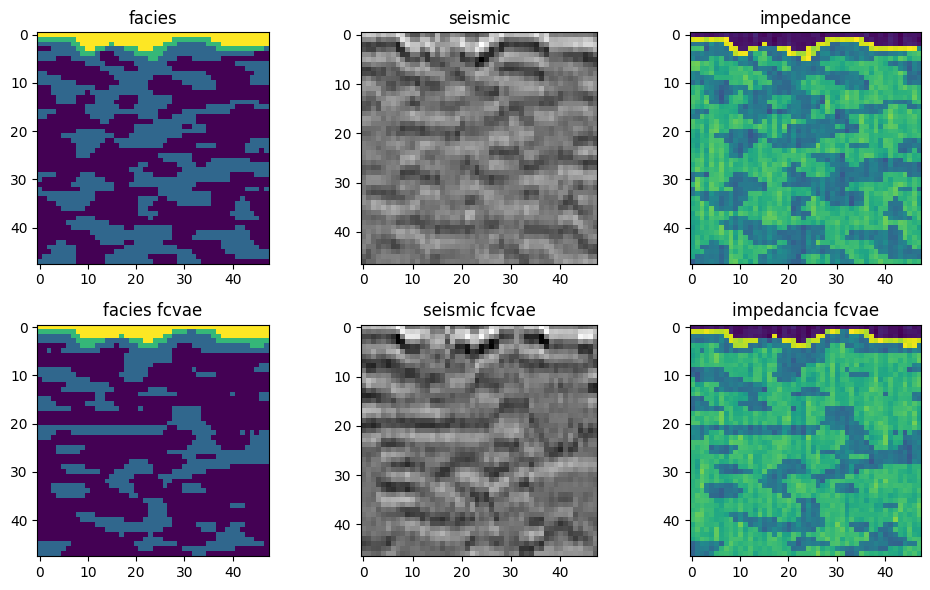

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  9


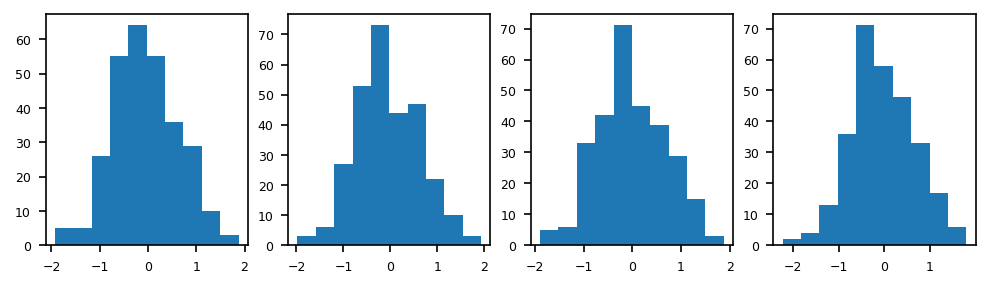

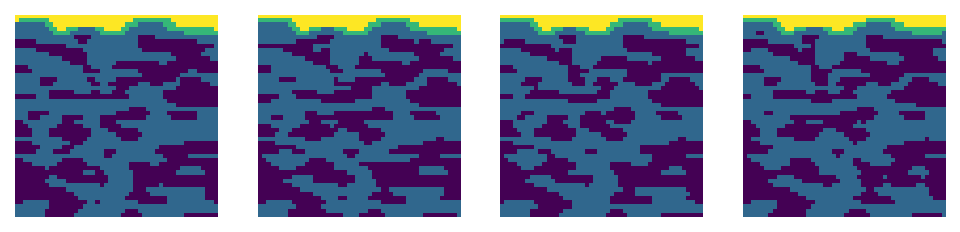

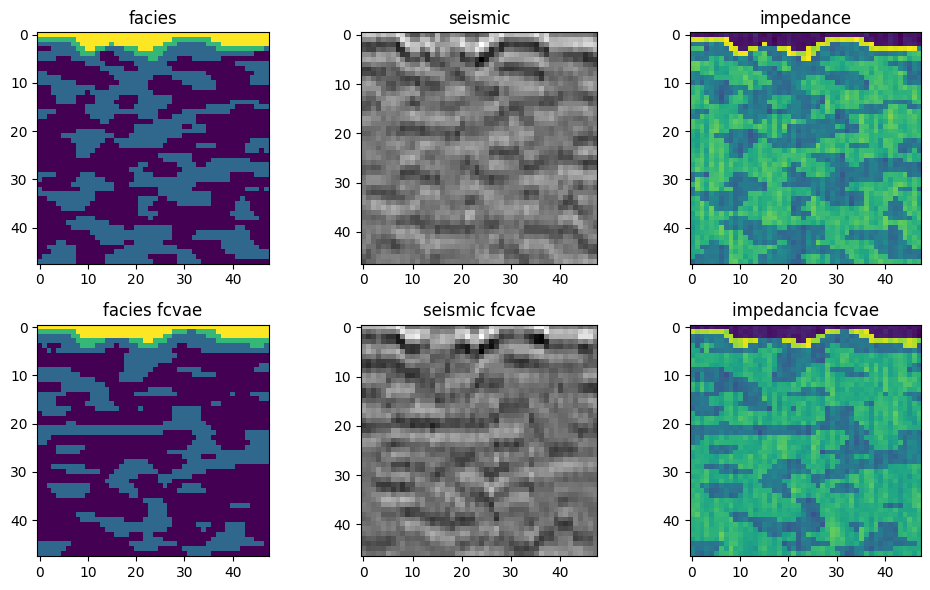

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  10


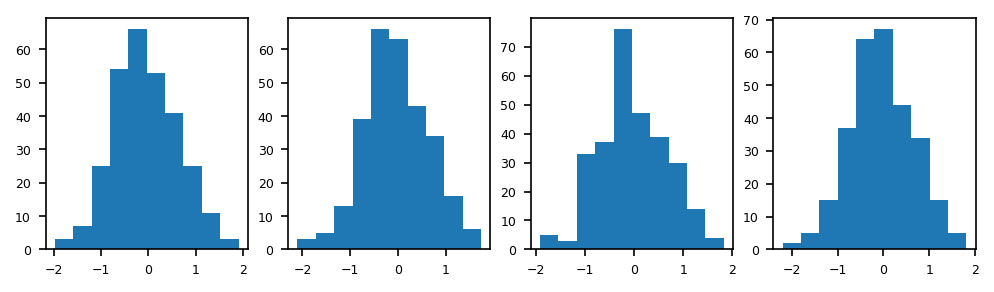

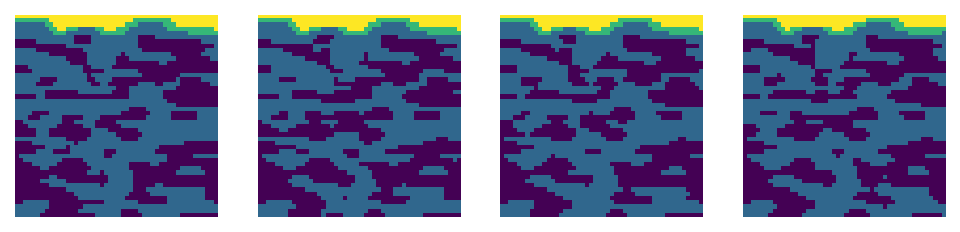

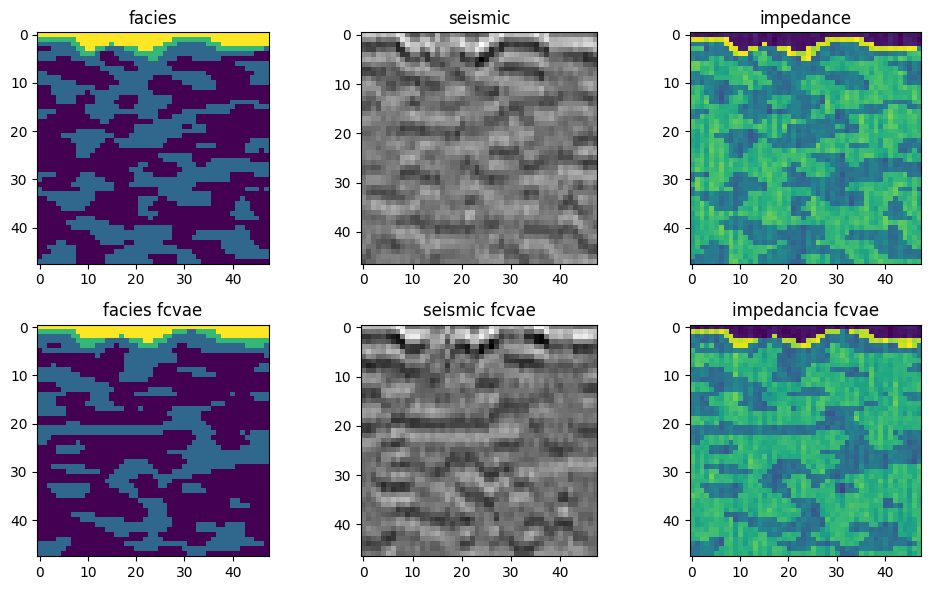

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  11


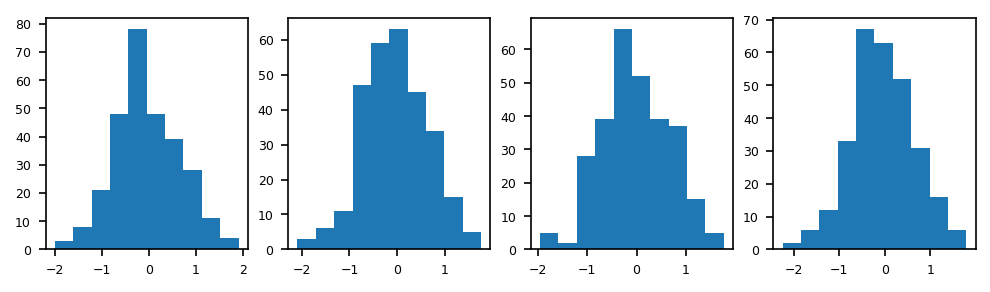

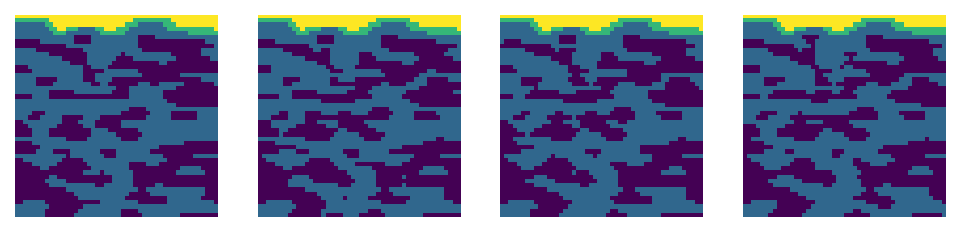

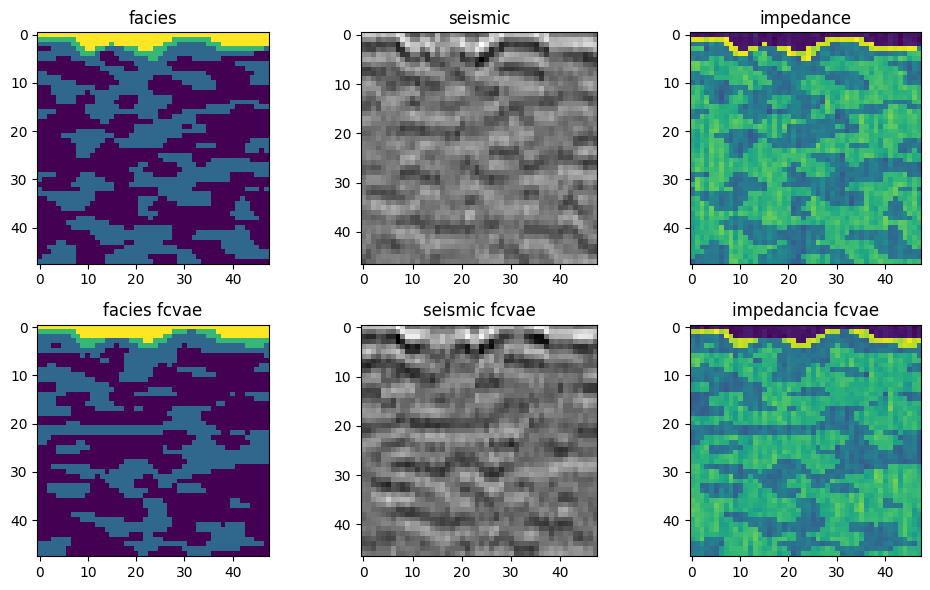

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  12


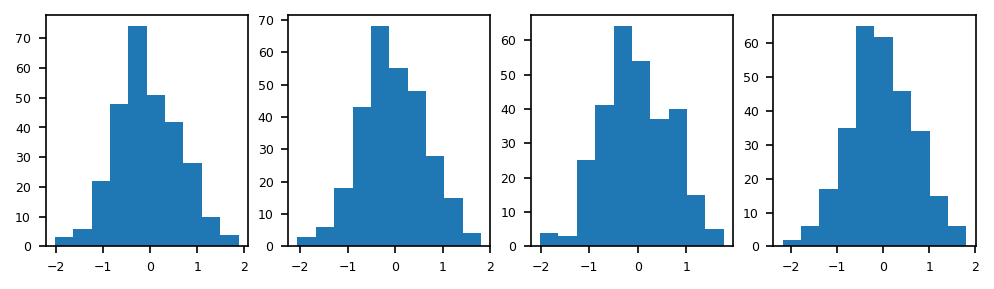

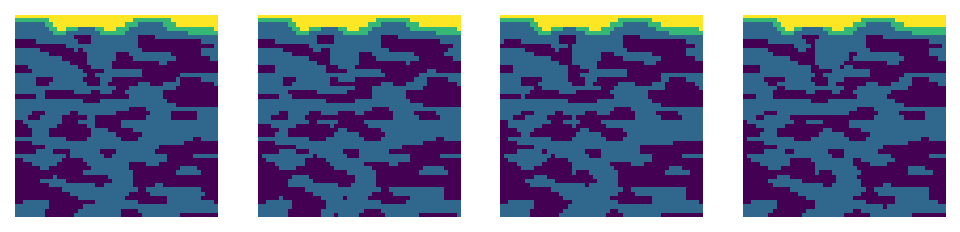

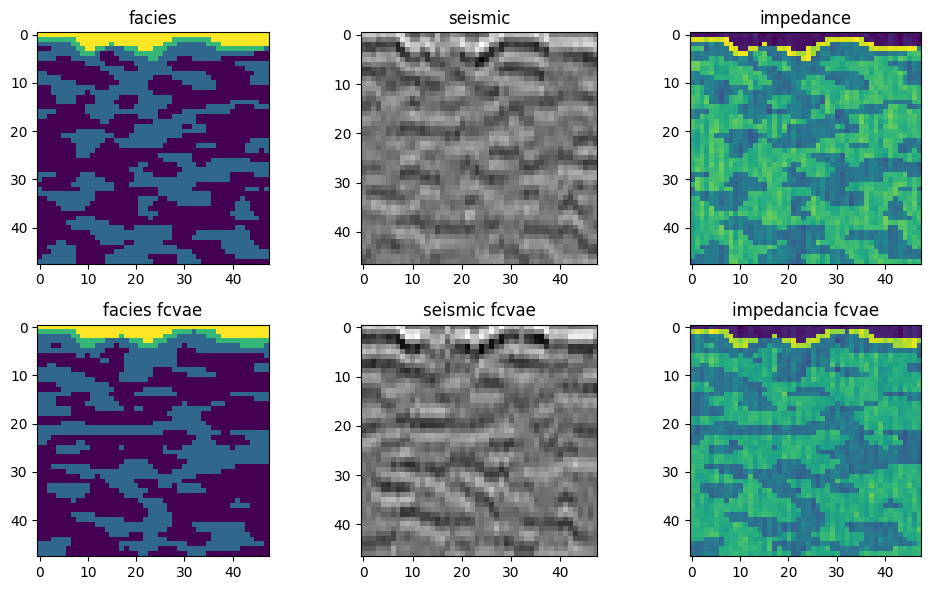

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Update  13


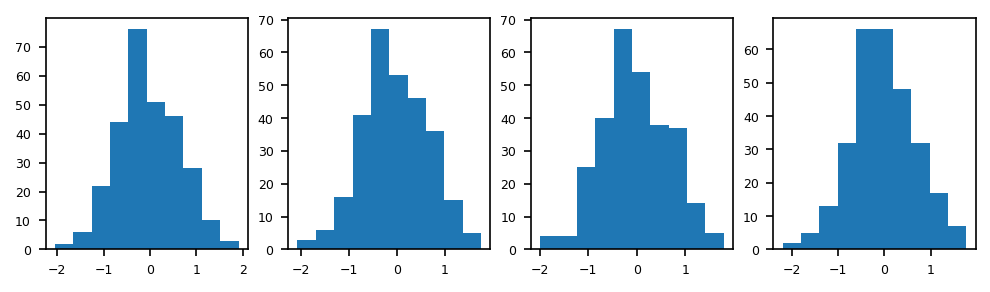

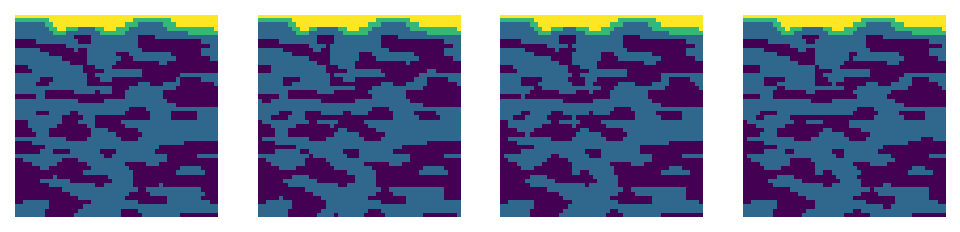

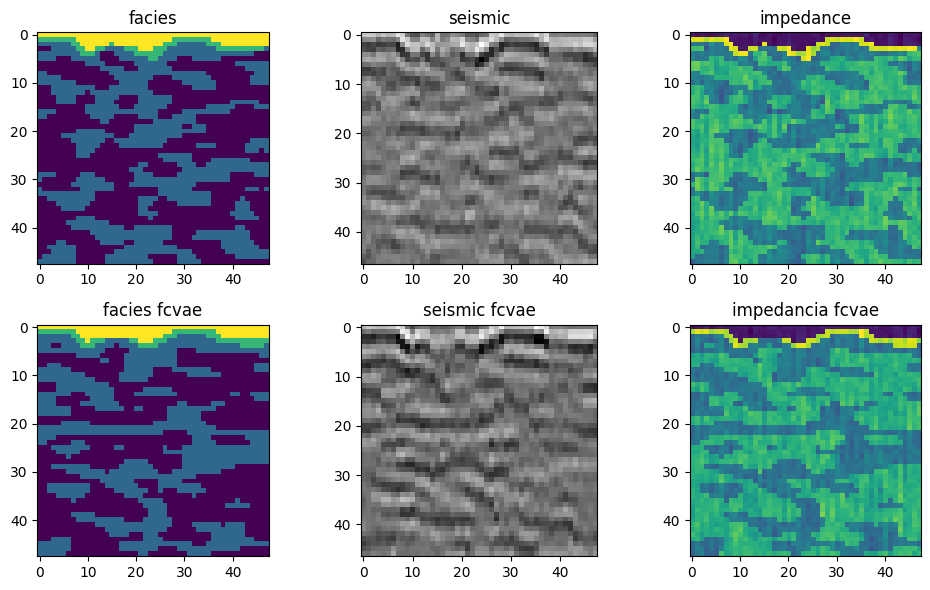

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.23784722 0.         0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.00051109 0.         0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.01028715 0.         0.         0.         0.         0.
 0.         0.        ]
Update  14


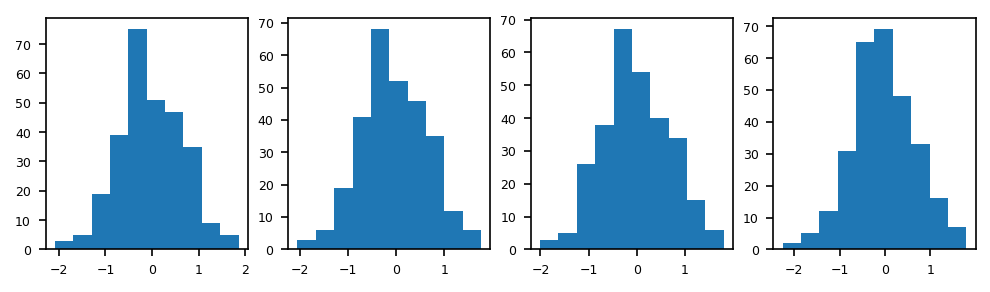

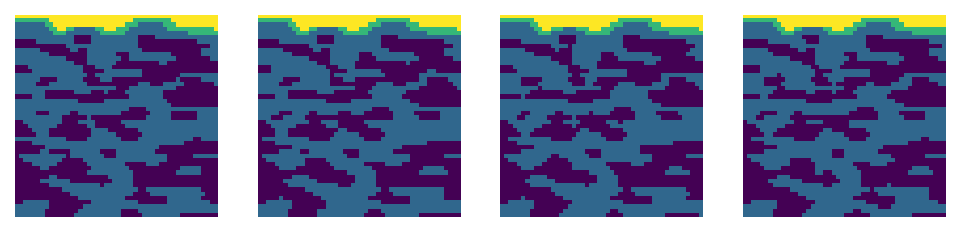

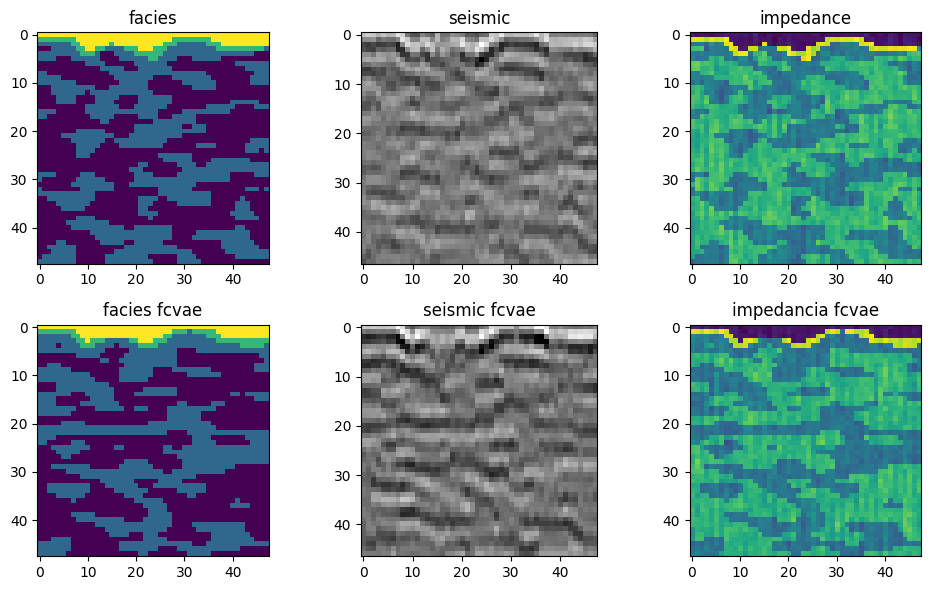

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.23784722 0.23480903 0.         0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.00051109 0.00048163 0.         0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.01028715 0.01004448 0.         0.         0.         0.
 0.         0.        ]
Update  15


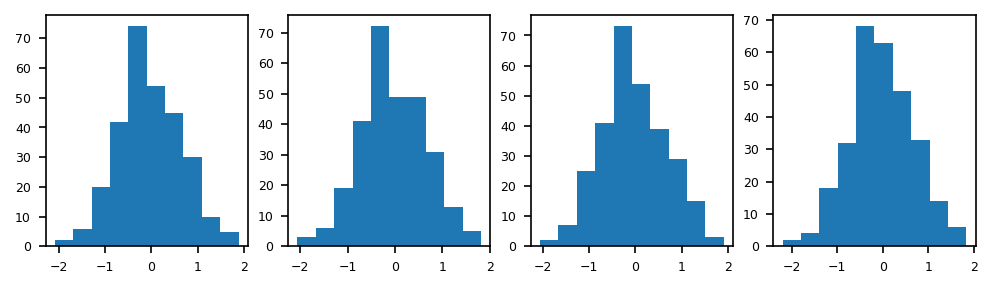

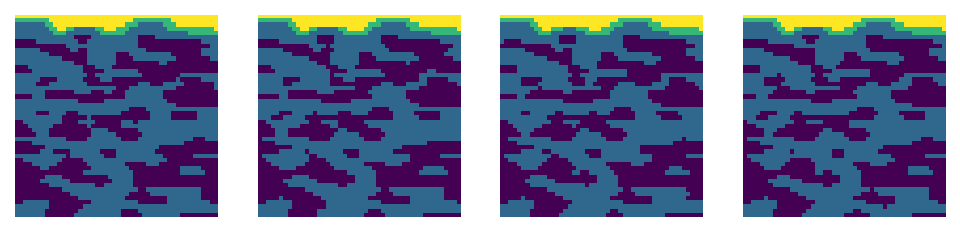

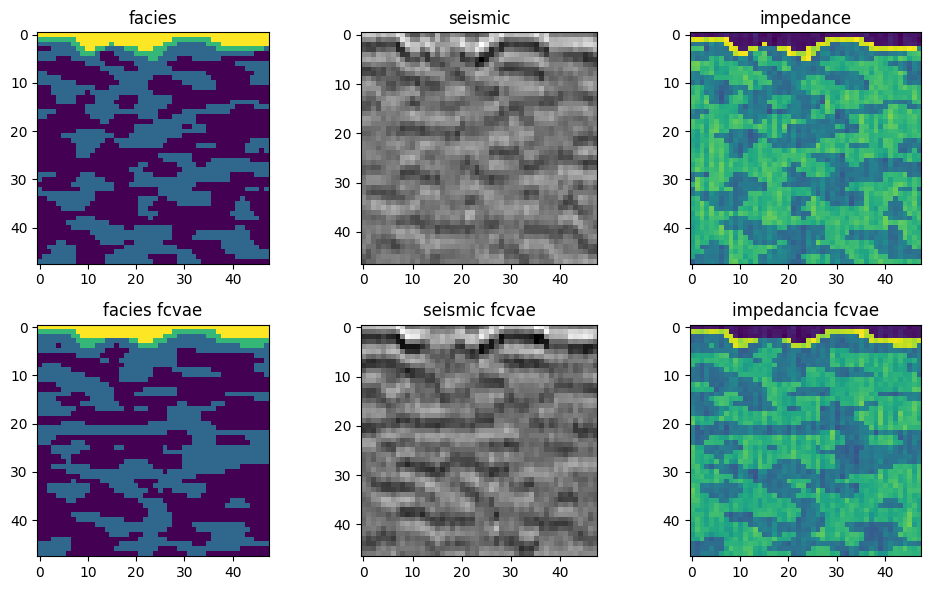

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.23784722 0.23480903 0.23220485 0.         0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.00051109 0.00048163 0.00050757 0.         0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.01028715 0.01004448 0.01026167 0.         0.         0.
 0.         0.        ]
Update  16


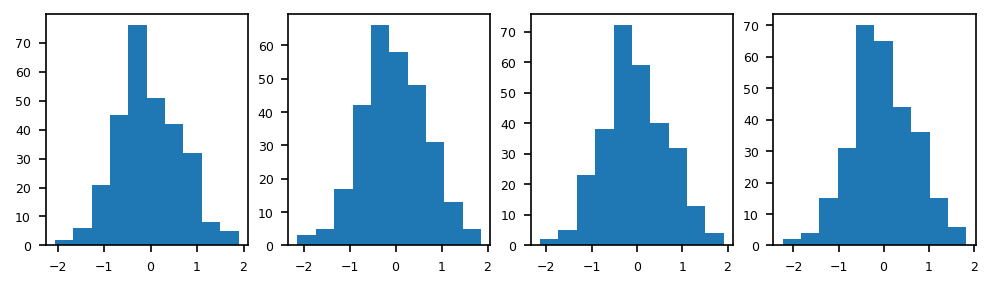

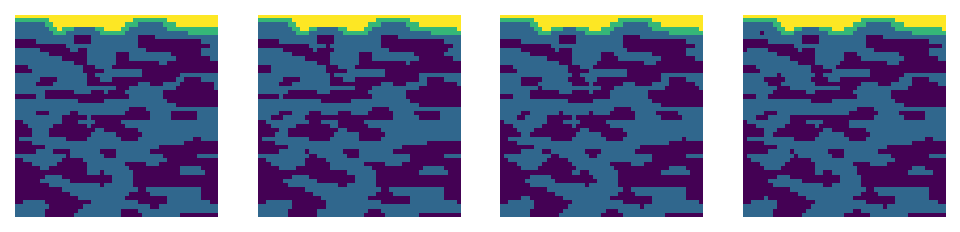

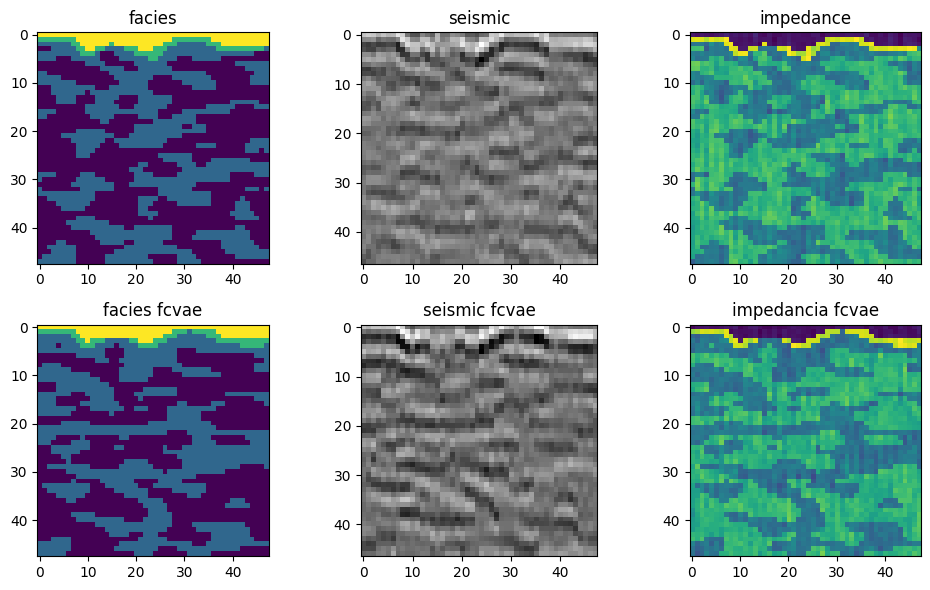

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.23784722 0.23480903 0.23220485 0.22699653 0.         0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.00051109 0.00048163 0.00050757 0.0004904  0.         0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.01028715 0.01004448 0.01026167 0.00990541 0.         0.
 0.         0.        ]
Update  17


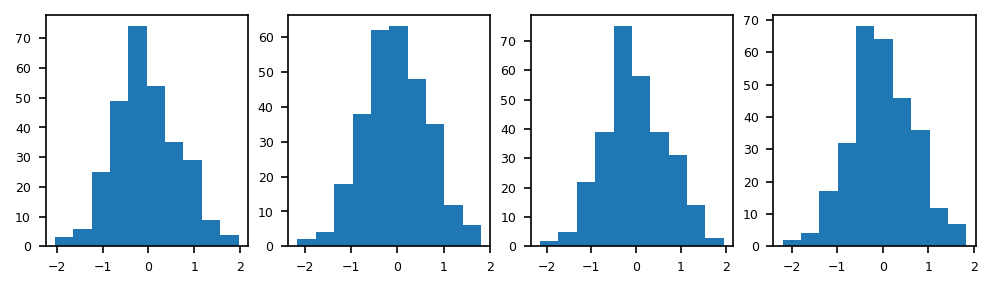

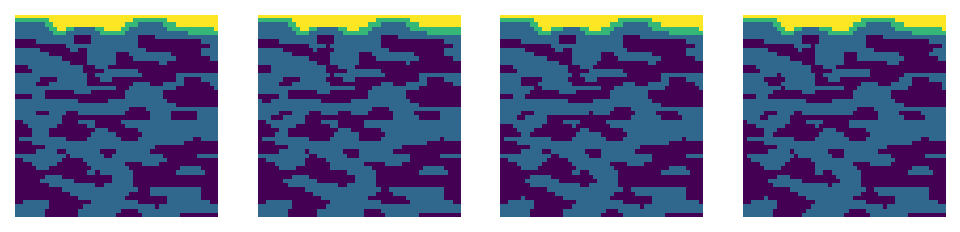

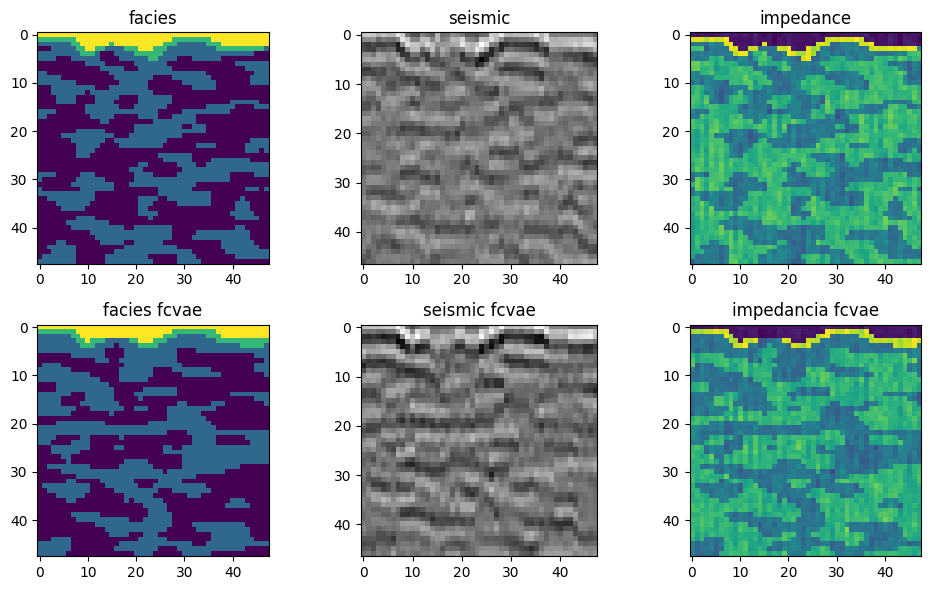

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.23784722 0.23480903 0.23220485 0.22699653 0.22395833 0.
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.00051109 0.00048163 0.00050757 0.0004904  0.00046142 0.
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.01028715 0.01004448 0.01026167 0.00990541 0.00979345 0.
 0.         0.        ]
Update  18


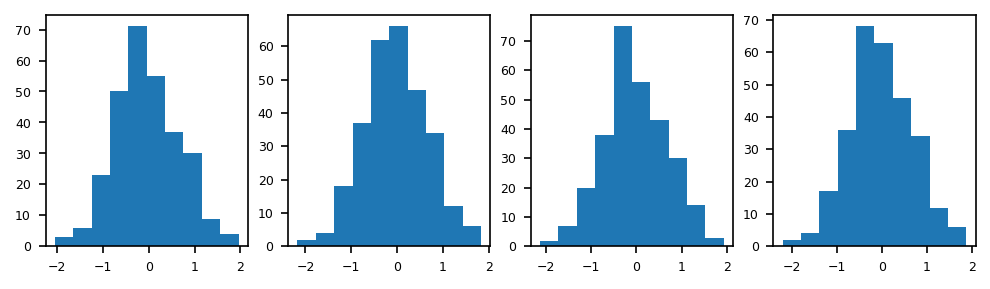

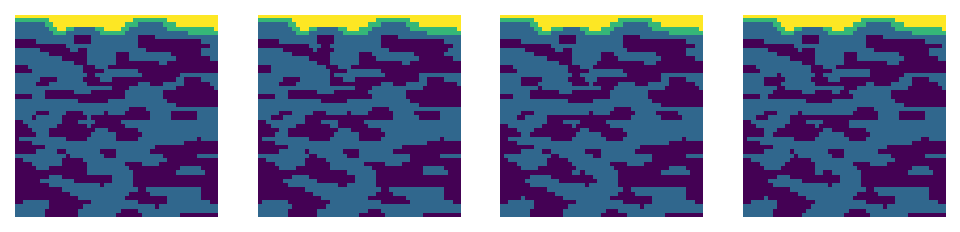

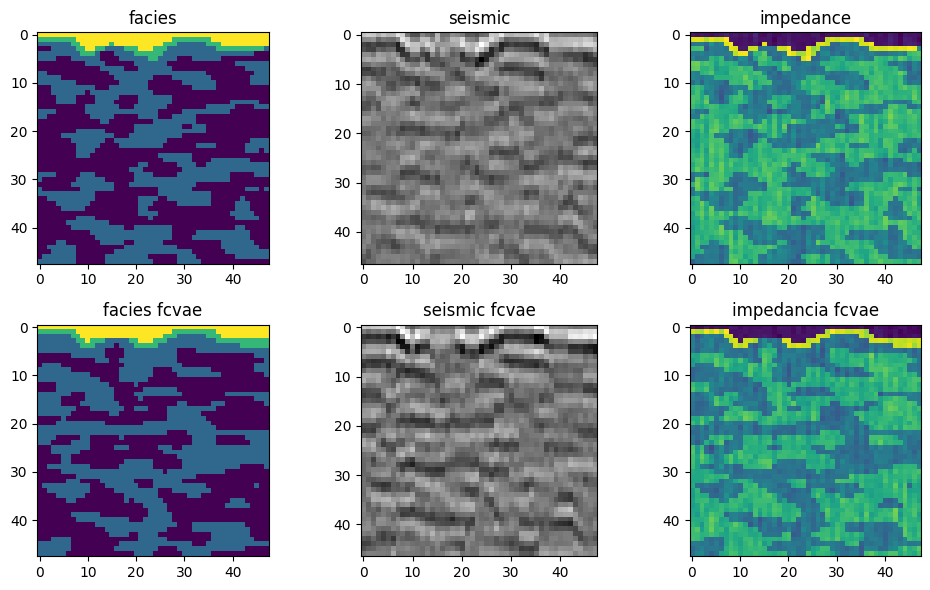

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.23784722 0.23480903 0.23220485 0.22699653 0.22395833 0.22743055
 0.         0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.00051109 0.00048163 0.00050757 0.0004904  0.00046142 0.00045873
 0.         0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.01028715 0.01004448 0.01026167 0.00990541 0.00979345 0.00924181
 0.         0.        ]
Update  19


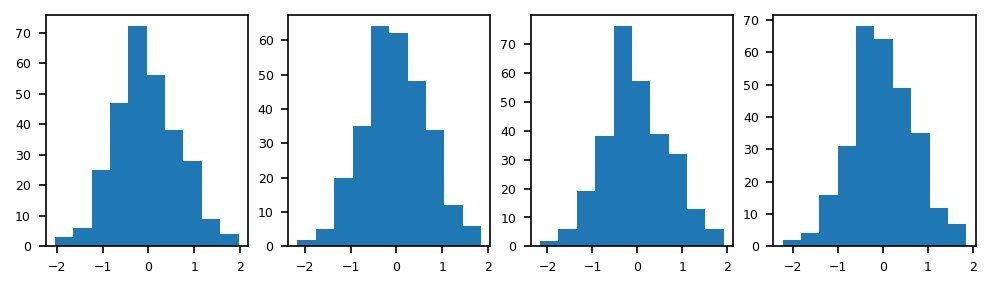

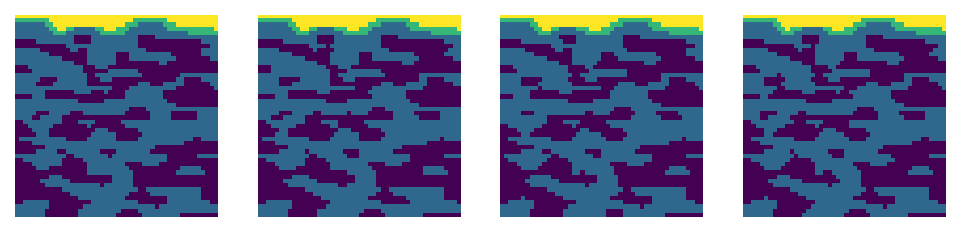

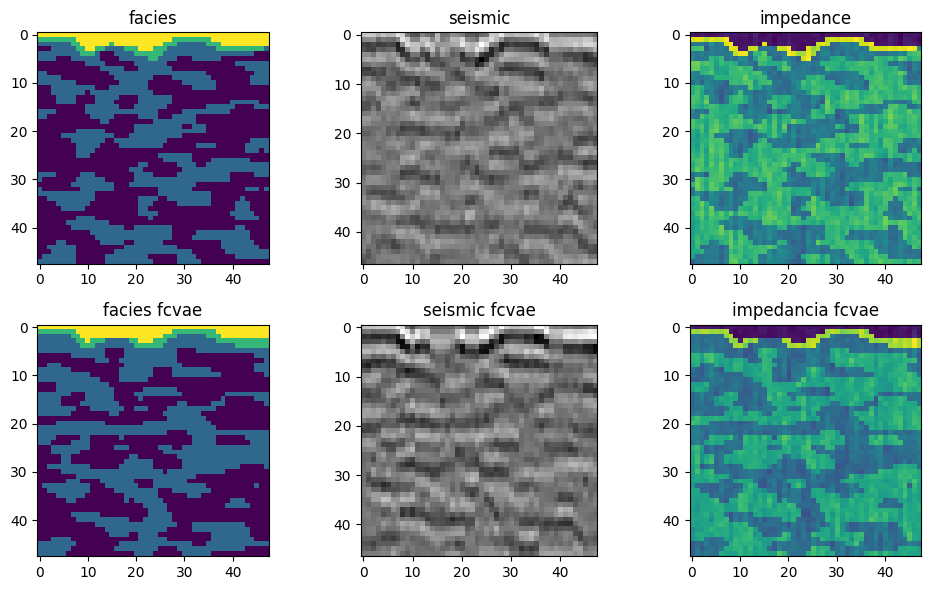

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.23784722 0.23480903 0.23220485 0.22699653 0.22395833 0.22743055
 0.22699653 0.        ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.00051109 0.00048163 0.00050757 0.0004904  0.00046142 0.00045873
 0.00044633 0.        ]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.01028715 0.01004448 0.01026167 0.00990541 0.00979345 0.00924181
 0.00980476 0.        ]
Update  20


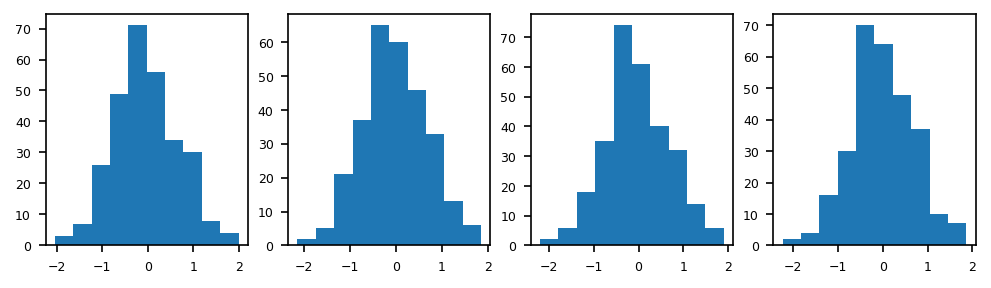

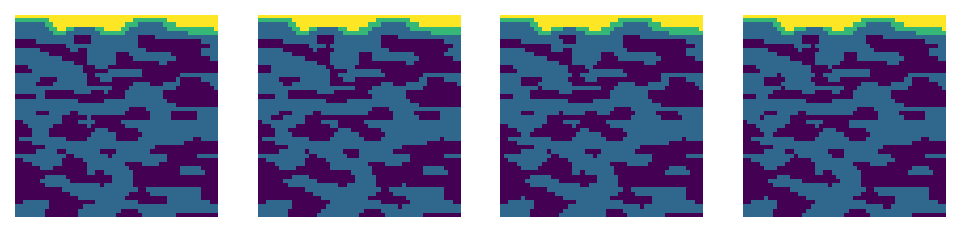

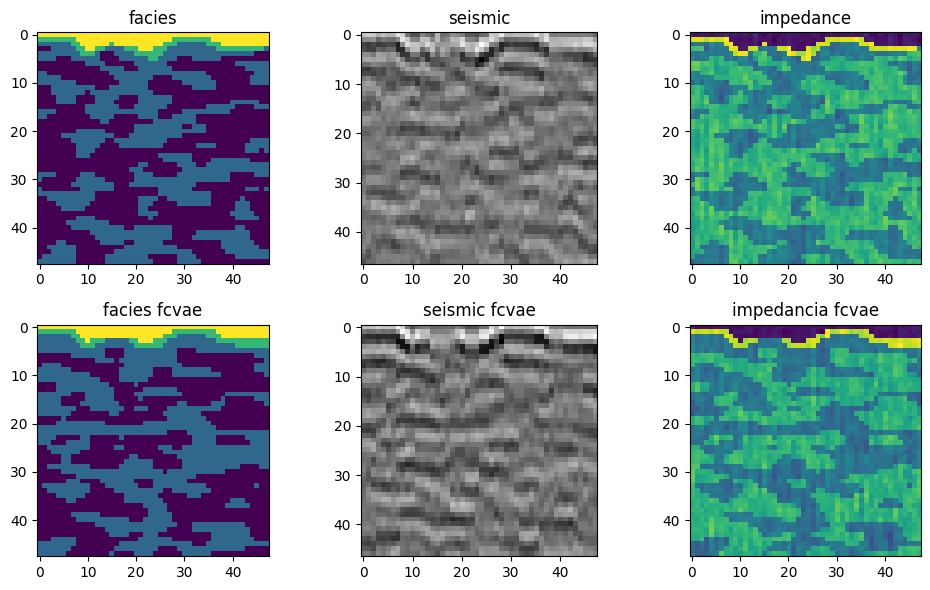

MSE model: [0.4375     0.41927084 0.39019096 0.35894096 0.32595485 0.30381945
 0.28819445 0.2703993  0.2673611  0.2560764  0.24782985 0.23567708
 0.23784722 0.23480903 0.23220485 0.22699653 0.22395833 0.22743055
 0.22699653 0.2265625 ]
MSE seismic: [0.00195185 0.00167861 0.00130082 0.00112861 0.00094125 0.00083421
 0.00073663 0.00067662 0.00061987 0.00059199 0.00055946 0.00054526
 0.00051109 0.00048163 0.00050757 0.0004904  0.00046142 0.00045873
 0.00044633 0.00046072]
MSE impedance: [0.02618998 0.02295043 0.01976702 0.01780917 0.01538339 0.01379779
 0.01293159 0.01180876 0.01133314 0.0113989  0.01095602 0.0105044
 0.01028715 0.01004448 0.01026167 0.00990541 0.00979345 0.00924181
 0.00980476 0.00999413]
Total time(s):  838.0461037158966


In [323]:
from IPython.core.debugger import set_trace

import time

Na = 20
Ne = 400
cut_factor = 1
alpha = tf.constant(20, dtype=tf.float32)

G = tf.constant(acoustic_foward_matrix(wavelet,I), np.float32)

ms = tf.Variable(tf.random.normal(shape=[Ne, fcvae.latent_dim,fcvae.latent_dim,fcvae.latent_size])*cut_factor)
ms = tf.Variable(tf.reshape(ms, shape=[Ne, fcvae.latent_dim*fcvae.latent_dim*fcvae.latent_size]))
seis = tf.Variable(tf.zeros([Ne, G.shape[0]*G.shape[1]]))
imps =  tf.Variable(tf.zeros([Ne, (G.shape[0]+1) * G.shape[1]]))
esmda_loss = tf.Variable(tf.zeros([Na]))
esmda_seismic_loss = tf.Variable(tf.zeros([Na]))
esmda_imp_loss = tf.Variable(tf.zeros([Na]))
### Sampling the reference model using the decoder
#rn = tf.random.normal(shape=[2, vae.latent_dim, vae.latent_dim, 1], mean=0, stddev=1)
#facies = np.around( vae.decoder.predict(rn)*3)[0]
#mr = tf.constant(facies.reshape(1,n,n,1), dtype=tf.float32)

### Reference model using MC
mr = tf.constant(ss.reshape(1,n,n,1), dtype=tf.float32)

seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(tf.reshape(mr,[n,n]).numpy(),PRIOR,G.numpy(), v_fact)
seis_exp = tf.cast(tf.reshape(seis_exp_tmp,[-1]), dtype=tf.float32)
imp_exp = tf.cast(tf.reshape(imp_exp_tmp,[-1]), dtype=tf.float32)

noise = tf.experimental.numpy.random.randn((I-1)*J)
noise = noise/tf.experimental.numpy.std(noise)
std_noise = tf.experimental.numpy.std(seis_exp)/tf.experimental.numpy.sqrt(signal2noise)
noise = noise*std_noise
#seis_exp = seis_exp + noise

fig, axs = plt.subplots(1,3)
fig.set_dpi(120)
axs[0].imshow(mr.numpy().reshape(n,n))
axs[1].imshow(seis_exp.numpy().reshape(n-1,n), cmap='gray')
axs[2].imshow(imp_exp.numpy().reshape(n,n))
plt.margins(0,0)
plt.show()

C_d = std_noise**2*tf.eye(seis_exp.shape[0])

start_time = time.time()



# Ensemble initialization

for e in range(0,Ne):
    lat = tf.reshape(ms[e:e+1],[1,fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size])
    facies = tf.Variable(fcvae.decode(lat))
    seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(tf.reshape(facies,[n,n]).numpy(),PRIOR,G.numpy(), v_fact)
    seis[e].assign(tf.cast(tf.reshape(seis_exp_tmp,[-1]), tf.float32))
    imps[e].assign(tf.cast(tf.reshape(imp_exp_tmp,[-1]), tf.float32))

print('Initial ensemble...')
plt_ensamble(tf.reshape(ms,[Ne,fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size]))


#mean = tf.Variable(tf.reduce_mean(ms, axis=0))

# Ensemble update
start_time = time.time()
# For update (u) in number of updates (updts)
for u in range (0,Na):
    print('Update ', u+1)
    #mean.assign(tf.reduce_mean(ms, 0))
    
    data_diff = seis.numpy() - np.tile(seis.numpy().mean(axis=0), (Ne,1) )
    model_diff = ms.numpy() - np.tile(ms.numpy().mean(axis=0), (Ne,1) )

    C_dd = tf.linalg.matmul(tf.transpose(data_diff), data_diff)/(Ne-1)
    C_md = tf.linalg.matmul(tf.transpose(model_diff), data_diff)/(Ne-1)

    #C_dd = tf.linalg.matmul(data_diff, tf.transpose(data_diff))/(Ne-1)
    #C_md = tf.linalg.matmul(model_diff, tf.transpose(model_diff))/(Ne-1)
    
    d_tio = seis_exp+tf.math.sqrt(alpha)*tf.random.normal(seis_exp.shape)*cut_factor*std_noise
    
    """
    fig, axs = plt.subplots(1,2, figsize=(10, 6))
    axs[0].imshow(seis_exp.numpy().reshape(n-1,n))
    axs[0].set_title('d')
    axs[1].imshow(d_tio.numpy().reshape(n-1,n))
    axs[1].set_title('d_tio')
    plt.show()
            
    fig, axs = plt.subplots(1,2,dpi=200)
    axs[0].set_title('Cdd')
    axs[1].set_title('Cmd')
    axs[0].imshow(C_dd[:100,:100])
    axs[1].imshow(C_md[:,:100])
    plt.show()
    """
    
    #K = tf.linalg.matmul(C_md, tf.linalg.pinv(C_dd + alpha*C_d, 0.001*tf.reduce_mean(tf.linalg.tensor_diag_part(C_d))))
    K = tf.linalg.matmul(C_md, tf.linalg.inv(C_dd + alpha*C_d) )   

    for e in range(0,Ne):     
        # MODIFIED! Cada componente do ensemble precisa de um ruido diferente. 
        d_tio = seis_exp + tf.math.sqrt(alpha)*tf.random.normal(seis_exp.shape)*cut_factor*std_noise

        dtio_dp = tf.reshape(d_tio - seis[e], [-1,1])
        Ksum = tf.reshape(tf.linalg.matmul(K,dtio_dp), ms[e].shape)

        ms[e].assign(ms[e] + Ksum)

        facies = tf.Variable(fcvae.decode(tf.reshape(ms[e:e+1], [1,fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size])))

        seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(tf.reshape(facies,[n,n]).numpy(),PRIOR,G.numpy(), v_fact)
        seis[e].assign(tf.cast(tf.reshape(seis_exp_tmp,[-1]), tf.float32))
        imps[e].assign(tf.cast(tf.reshape(imp_exp_tmp,[-1]), tf.float32))
        

    plt_ensamble(tf.reshape(ms,[Ne,fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size]))

    mean_facies = tf.reduce_mean(fcvae.decode(tf.reshape(ms,[Ne, fcvae.latent_dim, fcvae.latent_dim, fcvae.latent_size])), axis=0)

    facies_es = tf.reshape(mean_facies, [n,n])
    sismica_es, imp_es = facies_forward_model_2D(facies_es.numpy(),PRIOR,G.numpy(), v_fact)

    fig, axs = plt.subplots(2,3, figsize=(10, 6))
    axs[0,0].set_title('facies')
    axs[0,1].set_title('seismic')
    axs[0,2].set_title('impedance')
    axs[1,0].set_title('facies fcvae')
    axs[1,1].set_title('seismic fcvae')
    axs[1,2].set_title('impedancia fcvae')
    
    axs[0,0].imshow(tf.reshape(mr, [n,n]))
    axs[0,1].imshow(tf.reshape(seis_exp,[n-1,n]), cmap='gray')
    axs[0,2].imshow(imp_exp.numpy().reshape(n,n))
    axs[1,0].imshow(facies_es.numpy().reshape(n,n))
    axs[1,1].imshow(sismica_es.reshape(n-1,n), cmap='gray')
    axs[1,2].imshow(imp_es.reshape(n,n))
    fig.tight_layout()
    plt.show()
    plt.close()
    mse_model = tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(facies_es,-1), tf.expand_dims(tf.squeeze(mr),-1)))
    mse_seis = tf.reduce_mean(tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(sismica_es.reshape(n-1,n),-1), tf.expand_dims(tf.reshape(seis_exp,[n-1,n]),-1))))
    mse_imp = tf.reduce_mean(tf.reduce_mean(tf.keras.metrics.mse(tf.expand_dims(imp_es.reshape(n,n),-1), tf.expand_dims(tf.reshape(imp_exp,[n,n]),-1))))
    esmda_loss[u].assign(mse_model)
    esmda_seismic_loss[u].assign(mse_seis)
    esmda_imp_loss[u].assign(mse_imp)
    print('MSE model:', esmda_loss.numpy())
    print('MSE seismic:', esmda_seismic_loss.numpy())
    print('MSE impedance:', esmda_imp_loss.numpy())

run_time = time.time() - start_time
print('Total time(s): ', run_time)

run_config = {
  "Na": Na,
  "Ne": Ne,
  "m_loss": esmda_loss.numpy().tolist(),
  "d_obs_loss": esmda_seismic_loss.numpy().tolist(),
  "dimp_obs_loss": esmda_imp_loss.numpy().tolist(),
  "reference": [
    {"facies": tf.reshape(mr, [n,n]).numpy().tolist()},
    {"seismic": tf.reshape(seis_exp,[n-1,n]).numpy().tolist()},
    {"impedance": tf.reshape(imp_exp,[n,n]).numpy().tolist()}
  ],
  "posterior": [
    {"facies": facies_es.numpy().reshape(n,n).tolist()},
    {"seismic": sismica_es.reshape(n-1,n).tolist()},
    {"impedance": imp_es.reshape(n,n).tolist()}
  ],
  "run_time": run_time
}

file_name = "fvae_" + time.strftime("%Y%m%d_%H%M%S") + ".json"
with open(file_name, "w") as outfile:
    outfile.write(json.dumps(run_config, indent=4))


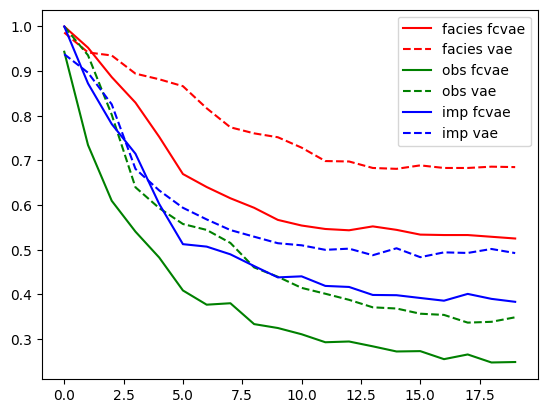

In [322]:
f = open('vae_20230621_135616.json')
data_vae = json.load(f)
f.close()
#f = open('fvae_20230620_165222.json')
f = open('fvae_20230621_143654.json')
data_fcvae = json.load(f)
f.close()
#ss = np.array(data["reference"][0]['facies'])
m_loss_vae = np.array(data_vae['m_loss'])
seismic_loss_vae = np.array(data_vae['d_obs_loss'])
imp_loss_vae = np.array(data_vae['dimp_obs_loss'])

m_loss_fcvae = np.array(data_fcvae['m_loss'])
seismic_loss_fcvae = np.array(data_fcvae['d_obs_loss'])
imp_loss_fcvae = np.array(data_fcvae['dimp_obs_loss'])

max_loss = max(m_loss_vae.max(), m_loss_fcvae.max())
max_seismic_loss = max(seismic_loss_vae.max(), seismic_loss_fcvae.max())
max_impedance_loss = max(imp_loss_vae.max(), imp_loss_fcvae.max())

plt.plot(m_loss_fcvae/max_loss, color='r', label='facies fcvae')
plt.plot(m_loss_vae/max_loss, '--', color='r', label='facies vae')
plt.plot(seismic_loss_fcvae/max_seismic_loss, color='g', label='obs fcvae')
plt.plot(seismic_loss_vae/max_seismic_loss, '--', color='g', label='obs vae')
plt.plot(imp_loss_fcvae/max_impedance_loss, color='b', label='imp fcvae')
plt.plot(imp_loss_vae/max_impedance_loss, '--', color='b', label='imp vae')


#plt.plot(m_loss_vae, color='r', label='model')
#plt.plot(m_loss_fcvae, '--', color='r', label='model')
#plt.plot(seismic_loss_vae/max_seismic_loss, color='g', label='seismic')
#plt.plot(seismic_loss_fcvae/max_seismic_loss, '--', color='g', label='seismic')
#plt.plot(imp_loss_vae/max_impedance_loss, color='b', label='imp')
#plt.plot(imp_loss_fcvae/max_impedance_loss, '--', color='b', label='imp')
plt.legend()
plt.show()

In [59]:
run_config = {
  "Na": Na,
  "Ne": Ne,
  "m_loss": esmda_loss.numpy().tolist(),
  "d_obs_loss": esmda_seismic_loss.numpy().tolist(),
  "dimp_obs_loss": esmda_imp_loss.numpy().tolist(),
  "reference": [
    {"facies": tf.reshape(mr, [n,n]).numpy().tolist()},
    {"seismic": tf.reshape(seis_exp,[n-1,n]).numpy().tolist()},
    {"impedance": tf.reshape(imp_exp,[n,n]).numpy().tolist()}
  ],
  "posterior": [
    {"facies": facies_es.numpy().reshape(n,n).tolist()},
    {"seismic": sismica_es.reshape(n-1,n).tolist()},
    {"impedance": imp_es.reshape(n,n).tolist()}
  ],
  "run_time": run_time
}

file_name = time.strftime("%Y%m%d_%H%M%S") + ".json"
print(timestr)
#print(json.dumps(run_config,indent=2))
print(json.dumps(run_config))
with open(file_name, "w") as outfile:
    outfile.write(json.dumps(run_config, indent=4))


20230612_181737.json
{"Na": 4, "Ne": 400, "m_loss": [0.4292534589767456, 0.3706597089767456, 0.37109375, 0.3559027910232544], "d_obs_loss": [0.0015811610501259565, 0.0013507328694686294, 0.0012090916279703379, 0.0009791203774511814], "dimp_obs_loss": [0.020788954570889473, 0.018467146903276443, 0.017409775406122208, 0.015144995413720608], "reference": [{"facies": [[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0], [2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0], [1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0

In [59]:
print(vae.encoder.summary())
print(vae.decoder.summary())


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 24, 24, 128)  1280        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 12, 12, 64)   73792       conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 12, 12, 32)   18464       conv2d_10[0][0]                  
____________________________________________________________________________________________

In [60]:
print(fcvae.encoder.summary())
print(fcvae.decoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 24, 24, 128)  1280        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 12, 12, 64)   73792       conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 12, 12, 32)   18464       conv2d_13[0][0]                  
____________________________________________________________________________________________